# Goodreads Recommender System Solution

At Goodreads, users come for one purpose: to discover their next favorite book. However, despite the platform’s vast richness in explicit user reviews, ratings, and genre tags, the current recommendation strategy falls disappointingly short, relying on randomized product displays rather than data-driven insights. This results in missed opportunities, both in terms of user satisfaction and of course business growth. We are a humble team of book-loving data engineers observed this system and highlighted a massive gap where avid readers aren't currently being connected to books they might love. Instead of helping users explore personalized, meaningful book suggestions, Goodreads bases a recommendation on chance, leading to frustration and largely reduced loyalty. 

We are here to change that for you. 

This notebook represents our efforts in designing, implementing, and evaluating a diverse set of recommender system strategies tailored for Goodreads. Our goal is to explore a range of cutting-edge techniques from a simple popularity-based RS to much more sophisticated and meticulously built hybrid models. Once we have built and explained each of these models, we will assess their potential to enhance user satisfaction and deliver a measurable business value to this company. More Specifically, in this notebook we promise to:
- Perform a deep exploratory data analysis (EDA) on Goodreads data to uncover patterns in user behavior, genre trends, and book ratings.
- Implement multiple types of recommendation systems:
  - Non-personalized (Random, Popular, Bayesian Popular)
  - Collaborative Filtering (User-based, Item-based and Model-based)
  - Content-Based (TF-IDF, BERT, NLP-enhanced)
  - Hybrid and Context-Aware models
- Evaluate each model with meaningful metrics that go beyond accuracy, including ranking quality, user coverage, diversity and personalization.
- Present a clear, accessible, and business-oriented summary of our findings—targeted to a non-technical audience, including the CEO.

Ultimately, this notebook serves as a **proof of concept**: a comprehensive investigation into what a modern, intelligent book recommendation engine could look like at Goodreads—and how it could reshape the way users interact with the platform.

## Setting up the Environment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import networkx as nx
import nltk

## The GoodReads Dataset

The GoodReads dataset is very representative of this companies general traffic. being scraped directly from users' public shelves, meaning that everyone can see it on web without login. This dataset contains roughly: 2,360,655 books (1,521,962 works, 400,390 book series, 829,529 authors). These datasets have multiple levels of user interaction, raging from adding to a "shelf", rating, and reading.
and 876,145 users; 228,648,342 user-book interactions in users' shelves (include 112,131,203 reads and 104,551,549 ratings). We made sure to create our proof of concept on data relevant.
It captures a wide range of user activity and book information, specifically focusing on public shelves. For your information in understadning the data throughout the notebook, we will describe what exactly a **"public shelf"** is: On Goodreads, users organize books they've read, want to read, or are currently reading into "shelves". By default, every user has basic shelves like "read", "currently-reading", and "to-read", but they can also create custom shelves (e.g., "fantasy favorites", "summer reading", etc.). When these shelves are marked public, anyone—including users who aren’t logged in—can view them. This allows insight into user-book interactions without violating privacy, making public shelves a rich source of implicit feedback for recommendation systems. 

The datasets we have engineered are composed of two main parts:

- Book Metadata 
- User-Book Interactions(loaded in two datasets to get implicit feedback)

Before we begin with the actual exploration of data we could use for our recommenders and explore the trends in the data, we mapped the user and book ids to simplify them for ease of use further down the road when we are building and evaluating our recommenders.

Due to it's originally massive size that we discovered when we loaded all of the data using it's API, we experienced significant crashes when running our program: Therefore we decided that the best cause of action would be to perform some large resampling. What we did was essentially take the top 5 percent of users with the most interactions in order to have the least sparse dataset possible when creating our solution, although we want to note that our implementation will be designed to scale with as much data as possible, accounting for the massive amount of user-activity goodreads' servers experience. First we downloaded through a public link which is where we got a plethora of complex and mixed up data in json.gz format, we then carefully extracted several csvs in such a way that only a top subset of interacting users remains and the corresponding books are made into a metadata.csv with their relevant information. In conclusion, this dataset will allow us to deeply explore various techniques and methods in order to clearly add value to this company.

### Loading and Introducing the Dataset

In [2]:
# Set the directory where the extracted CSV files are located
DATA_DIR = './GoodreadsData1'

# Load the datasets
reviews_df = pd.read_csv(os.path.join(DATA_DIR, 'reviews.csv'))
books_df = pd.read_csv(os.path.join(DATA_DIR, 'books.csv'))
genres_df = pd.read_csv(os.path.join(DATA_DIR, 'genres.csv'))

# Display a quick summary of each dataset
print("Reviews dataset shape:", reviews_df.shape)
print("Books dataset shape:", books_df.shape)
print("Genres dataset shape:", genres_df.shape)

Reviews dataset shape: (8513777, 11)
Books dataset shape: (1575636, 29)
Genres dataset shape: (1575636, 2)


In [3]:
reviews_df.head()

,review_id,user_id,book_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,5cd416f3efc3f944fce4ce2db2290d5e,1,1,5,Mind blowingly cool. Best science fiction I've...,Fri Aug 25 13:55:02 -0700 2017,Mon Oct 09 08:55:59 -0700 2017,Sat Oct 07 00:00:00 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,16,0
1,dfdbb7b0eb5a7e4c26d59a937e2e5feb,1,2,5,This is a special book. It started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1
2,5e212a62bced17b4dbe41150e5bb9037,1,3,3,I haven't read a fun mystery book in a while a...,Mon Jul 24 02:48:17 -0700 2017,Sun Jul 30 09:28:03 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,6,0
3,fdd13cad0695656be99828cd75d6eb73,1,4,4,"Fun, fast paced, and disturbing tale of murder...",Mon Jul 24 02:33:09 -0700 2017,Sun Jul 30 10:23:54 -0700 2017,Sun Jul 30 15:42:05 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,22,4
4,bd0df91c9d918c0e433b9ab3a9a5c451,1,5,4,A fun book that gives you a sense of living in...,Mon Jul 24 02:28:14 -0700 2017,Thu Aug 24 00:07:20 -0700 2017,Sat Aug 05 00:00:00 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,8,0


This dataset captures detailed user-generated book reviews from Goodreads' public shelves.
Each row represents a review a user left on a specific book. Here's what each column means:

- review_id: A unique anonymized identifier for each review.
- user_id: An anonymized ID representing the user who left the review.
- book_id: An anonymized ID for the book being reviewed (can be joined with the book metadata).
- rating: The user’s numerical rating for the book, typically from 1 to 5(Explicit), with a 0 representing a click but no rating interaction(Implicit).
- review_text: The actual text content of the user’s review.
- date_added: When the review was first posted.
- date_updated: If the user edited their review, this shows the last update timestamp.
- read_at: The date the user marked the book as “read”, will be null if it hasn't been marked(could be valuable implicit data).
- started_at: When the user started reading the book.
- n_votes: Number of helpful votes the review received from other users.
- n_comments: Number of comments other users left on the review.

This rich set of attributes gives us valuable insights into user behavior, preferences, and engagement—ideal for experimenting with sentiment-aware or content-based recommenders.

In [4]:
books_df.head()

,book_id,title,title_without_series,authors,description,publisher,publication_year,publication_month,publication_day,edition_information,...,country_code,language_code,popular_shelves,similar_books,format,link,url,image_url,work_id,genre
0,901426,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,604031:,NaN,St. Martin's Press,1984.0,9.0,1.0,NaN,...,US,NaN,"count:3,name:to-read;count:1,name:p;count:1,na...",NaN,Paperback,https://www.goodreads.com/book/show/5333265-w-...,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5400751.0,"{'history, historical fiction, biography': 1}"
1,1077204,Good Harbor,Good Harbor,626222:,"Anita Diamant's international bestseller ""The ...",Simon & Schuster Audio,2001.0,10.0,1.0,Abridged,...,US,NaN,"count:2634,name:to-read;count:160,name:fiction...",8709549;17074050;28937;158816;228563;11296581;...,Audio CD,https://www.goodreads.com/book/show/1333909.Go...,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1323437.0,"{'fiction': 219, 'history, historical fiction,..."
2,345682,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",10333:,Omnibus book club edition containing the Ladie...,"Nelson Doubleday, Inc.",1987.0,NaN,NaN,Book Club Edition,...,US,eng,"count:58,name:to-read;count:15,name:fantasy;co...",19997;828466;1569323;425389;1176674;262740;374...,Hardcover,https://www.goodreads.com/book/show/7327624-th...,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,8948723.0,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,90033,Best Friends Forever,Best Friends Forever,9212:,Addie Downs and Valerie Adler were eight when ...,Atria Books,2009.0,7.0,14.0,NaN,...,US,eng,"count:7615,name:to-read;count:728,name:chick-l...",6604176;6054190;2285777;82641;7569453;7010683;...,Hardcover,https://www.goodreads.com/book/show/6066819-be...,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6243154.0,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,1476483,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls,3041852:,"Relates in vigorous prose the tale of Aeneas, ...",Yesterday's Classics,2006.0,9.0,13.0,NaN,...,US,NaN,"count:56,name:to-read;count:10,name:currently-...",NaN,Paperback,https://www.goodreads.com/book/show/287141.The...,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,278578.0,"{'history, historical fiction, biography': 9, ..."


The books_df dataset represents the vast metadata each book item that has been interacted with by a top-interacting Goodreads user, containing the title, description, genre and which popular shelves the book has appeared on and its' respective count on those shelves. This rich metadata can be leveraged very effectively by us in a content-based recommender system which we have established is definitely worth exploring for our PoC Goodreads Recommender solution. In addition to textual information like title and description, the dataset also contains valuable categorical and count-based features—such as the number of ratings, average rating, and shelf frequency—which can help us model book popularity, niche appeal, and reader sentiment. The inclusion of genre and shelf tags offers a multi-dimensional view of a book’s identity, enabling personalized matches based not just on user preferences, but also on book characteristics that align with specific reading habits or themes. These features position the metadata as a foundational pillar for both standalone content-based filtering and hybrid recommender strategies that combine collaborative signals with item attributes. We see that there is a field called similar books, which could be pivotal in building our recommender and is definitely worth exlporing.

We also managed to pull a dataset later on of all the authors in Goodreads, although they haven't been matched to the resampled books yet but we will take care of this in our EDA.

In [5]:
authors_df = pd.read_csv(os.path.join(DATA_DIR, 'authors.csv'))
authors_df.head()

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


Here we see the list of all authors within this Goodreads Dataset and some unexpectedly included but very important information in the other collumns such as ratings count, average rating or text review count, all of these can be used in creating either content based or even some type of popular recommender. We will explore all of these options later on.

## Slight Formatting of the data

The team realized that we did not have a rich enough source of implicit feedback to properly use it with our recommenders once they were built, so we brought a new dataset into the mix, an interactions.csv file containing a boolean value for "is_reviewed" which we thought would be perfect as a source of implicit feedback and therefore decided to make use of it, we simply took the interactions datasets, we resampled it, keeping only fields in which is_reviewed was 0 and then merged both datasets to have a balanced representation of the "is_reviewed" field. We also created a new dataset representation for reviews to have more organization

In [6]:
reviews_df = pd.read_csv(os.path.join(DATA_DIR, 'reviews_df.csv'))

In [7]:
ratings_df = pd.read_csv(os.path.join(DATA_DIR, 'ratings_df.csv'))

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/3354701825.py:1: DtypeWarning: Columns (4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_df = pd.read_csv(os.path.join(DATA_DIR, 'ratings_df.csv'))


In [8]:
ratings_df = ratings_df.drop(columns=['read_at', 'date_updated', 'is_read'])

In [9]:
ratings_df.head()

,user_id,book_id,rating,date_added,started_at,is_reviewed
0,1,1,5.0,Fri Aug 25 13:55:02 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,1
1,1,2,5.0,Sun Jul 30 07:44:10 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,1
2,1,3,3.0,Mon Jul 24 02:48:17 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,1
3,1,4,4.0,Mon Jul 24 02:33:09 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,1
4,1,5,4.0,Mon Jul 24 02:28:14 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,1


## Exploratory Data Analysis With Formatting and Feature Extraction/Engineering

Before designing an effective recommendation system, it's critical to develop a deep understanding of the data that powers it. In this section, we conduct a thorough Exploratory Data Analysis (EDA) to uncover insights into user behavior, feedback patterns, book characteristics, and the nature of interactions on Goodreads.

From a business perspective, this exploration helps us identify pain points and opportunities for improving recommendation relevance and user satisfaction. Technically, it allows us to assess data quality, detect potential biases, and strategically engineer features that will inform and enhance downstream recommender models.

We will divide our analysis into key segments:

1. General Information to understand data structure and volume.
2. Explicit Feedback (e.g., ratings and reviews) to capture clear user preferences.
3. Implicit Feedback (e.g., shelf activity) to infer interests from behavior.
4. Metadata Analysis in two parts, covering both book-level attributes and authors.
5. Feature Engineering, where we transform raw signals into model-ready inputs for content-based, collaborative, and hybrid recommenders.

This EDA serves as the foundation for designing a robust, scalable, and data-driven Proof of Concept recommender system tailored to Goodreads' unique ecosystem.

### 1: General Information

In [10]:
def stats(ratings_df, user, item):
  n_ratings = ratings_df.shape[0]
  n_users = ratings_df[user].nunique()
  n_items = ratings_df[item].nunique()
  print(f'We observe {n_ratings} ratings by {n_users} users to {n_items} books')
  return n_ratings, n_users, n_items

n_ratings, n_users, n_items = stats(ratings_df, 'user_id', 'book_id')

We observe 11513006 ratings by 24290 users to 1575636 books


This raises some concerns when thinking about collaborative filtering RS's, if there is a huge variety of books and substantially less users who make up the ratings for those books, the similarity metrics will be harder to infer from the user-interaction matrix, however, The original goodreads dataset had roughly 2.3 million books and 800 thousand users so this ratio is expected when sampling the top users with the most interactions.

In [11]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11513006 entries, 0 to 11513005
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   book_id      int64  
 2   rating       float64
 3   date_added   object 
 4   started_at   object 
 5   is_reviewed  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 527.0+ MB


In [12]:
print("Reviews Summary:")
ratings_df = ratings_df[ratings_df["rating"] != 0]
display(ratings_df.describe().T)

Reviews Summary:


,count,mean,std,min,25%,50%,75%,max
user_id,11192827.0,66412.408582,114061.364915,1.0,7603.0,15516.0,28051.0,442377.0
book_id,11192827.0,291917.301096,368734.531354,1.0,28217.0,127398.0,416000.0,1575636.0
rating,11192827.0,3.815811,1.013530,1.0,3.0,4.0,5.0,5.0
is_reviewed,11192827.0,0.732040,0.442897,0.0,0.0,1.0,1.0,1.0


Here we have our newly curated ratings_df dataset, as we can see it contains both explicit and implicit feedback, though from the values we can already see both an imbalance in the is_reviewed field and raating field, suggesting some bias in the data that we will need to handle graciously further on. This initial statistical summary offers us with an overview of the user-book interaction data. We observe that the dataset includes 11 million reviews from users, with user IDs and book IDs spanning a wide range, reflecting the diversity of readers and books on Goodreads. The average rating given by users is approximately 3.7, aligning with a generally positive sentiment which is expected as usually a user will only leave a rating when they feel either strongly well about a book or utterly dissapointed. We see that the average for reviewed or not is quite high, we can already expect some bias during training but we may change our data(oversampling or undersampling) in order to make our models more personalized.

In [13]:
# Make sure all values in n_votes and n_comments are non-negative
reviews_df['n_votes'] = reviews_df['n_votes'].abs()
reviews_df['n_comments'] = reviews_df['n_comments'].abs()
print("Reviews Summary:")
display(reviews_df.describe().T)

Reviews Summary:


,count,mean,std,min,25%,50%,75%,max
user_id,8513777.0,11526.805423,6741.292121,1.0,5707.0,11500.0,17327.0,23266.0
book_id,8513777.0,305621.894497,383830.173703,1.0,27307.0,131403.0,446237.0,1575636.0
n_votes,8513777.0,1.578470,10.870353,0.0,0.0,0.0,1.0,16695.0
n_comments,8513777.0,0.434666,3.305811,0.0,0.0,0.0,0.0,1632.0


We noticed here that most book reviews receive few votes or comments, highlighting a strong skew in user engagement—likely dominated by a small number of highly popular books which we will explore further. We also observe that the minimum ratings is a 0 value, which through research we know is a form of implicit data, representing a click on the book but no other rating made.

In [14]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575636 entries, 0 to 1575635
Data columns (total 29 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   book_id               1575636 non-null  int64  
 1   title                 1575630 non-null  object 
 2   title_without_series  1575630 non-null  object 
 3   authors               1575636 non-null  object 
 4   description           1360302 non-null  object 
 5   publisher             1169810 non-null  object 
 6   publication_year      1210399 non-null  float64
 7   publication_month     1053714 non-null  float64
 8   publication_day       967946 non-null   float64
 9   edition_information   142318 non-null   object 
 10  isbn                  969086 non-null   object 
 11  isbn13                1091077 non-null  object 
 12  asin                  306963 non-null   object 
 13  kindle_asin           737444 non-null   object 
 14  num_pages             1102513 non-

Instantly we observe that while most fields are well-populated, several key attributes like description, publisher, publication date components, and ISBN identifiers contain notable amounts of missing data. These gaps could potentially impact content-based recommendation performance if not handled properly. Therefore, we may need to consider imputation strategies, feature omission, or fallback logic in our models depending on the importance of the affected attributes. Lets explore these missing values slightly more clearly as missing value may be relevant and could be made into a feature if appropriate.

<Figure size 1200x600 with 0 Axes>

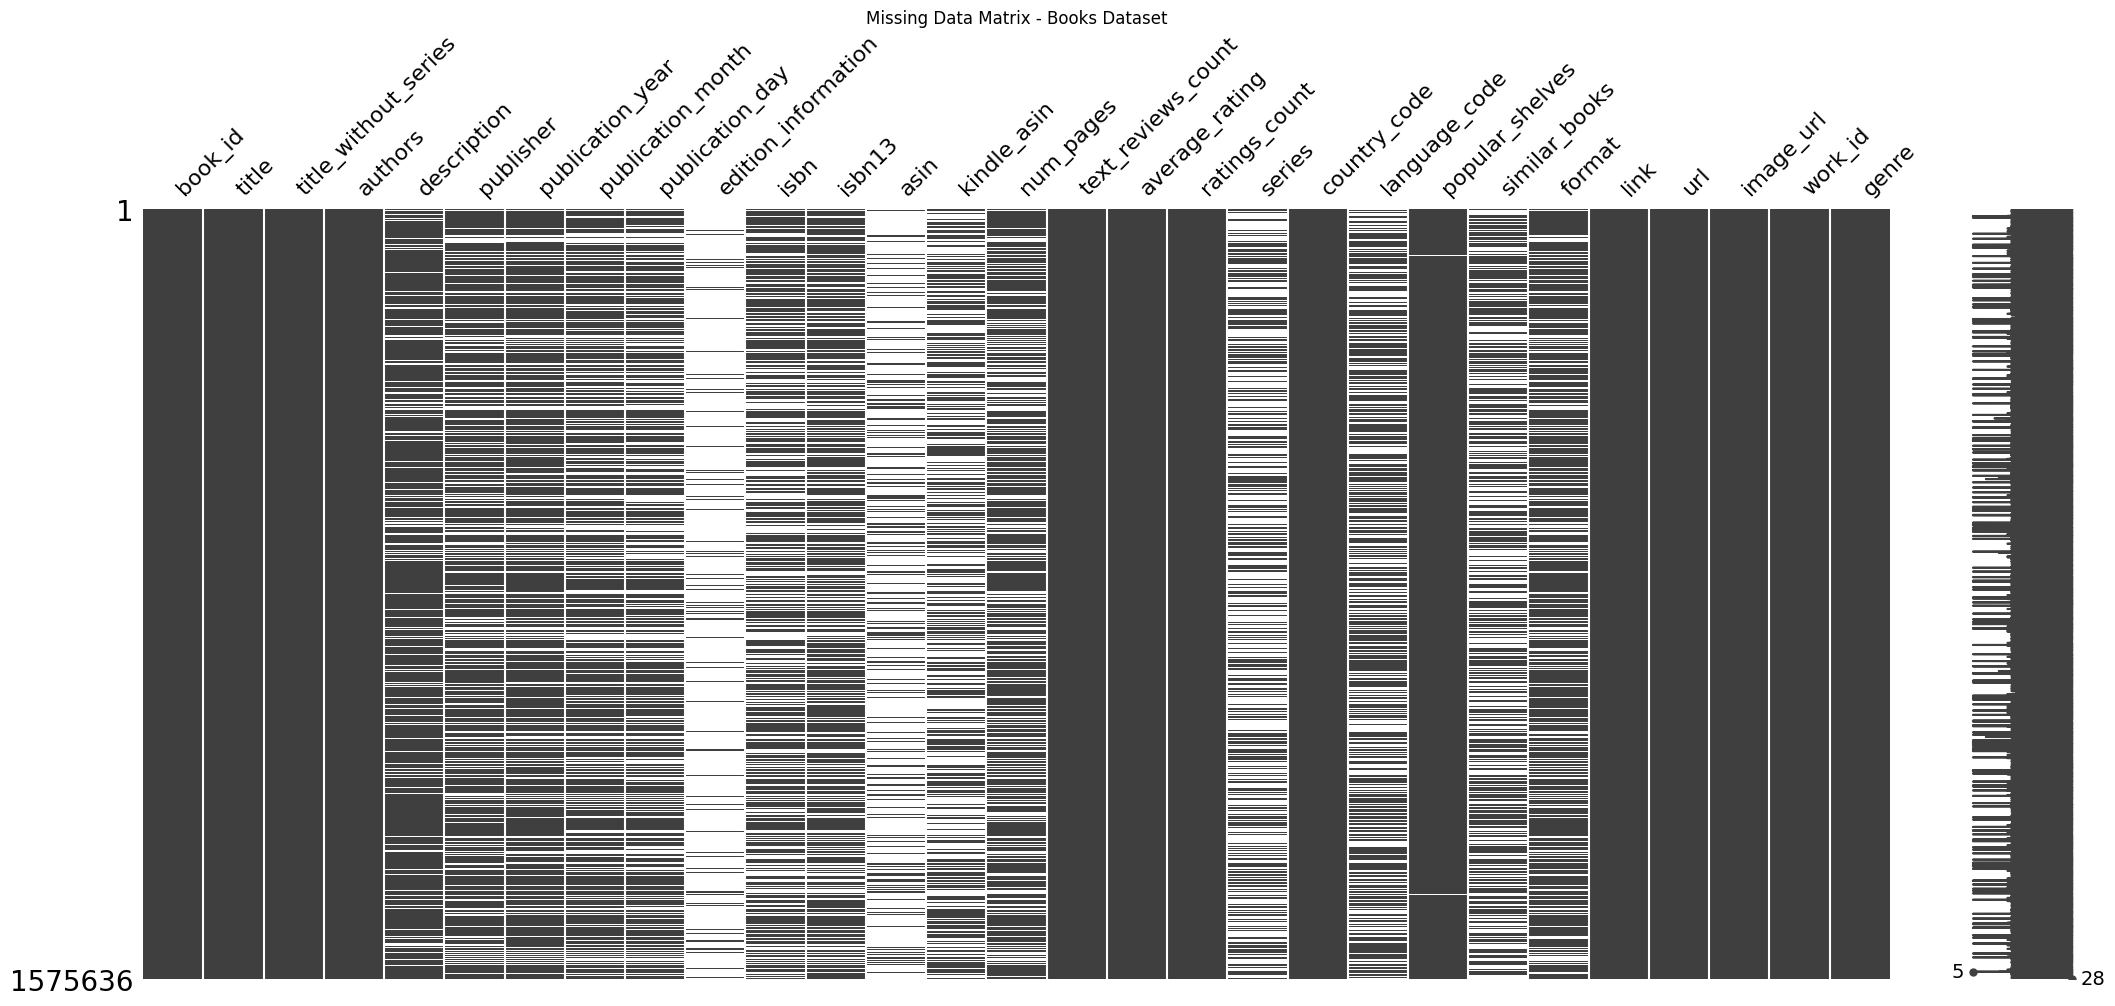

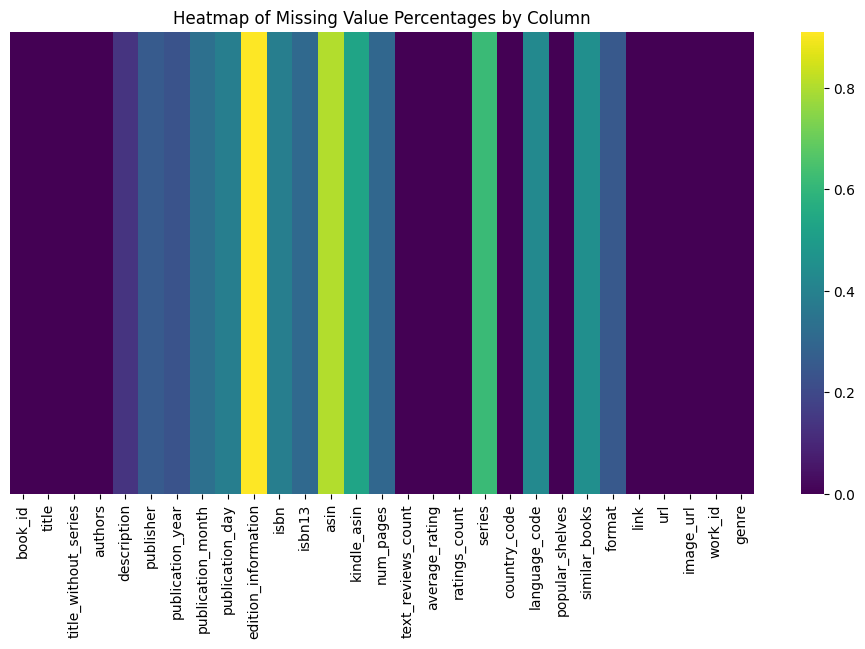

In [15]:
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

# Display a matrix of missing values
plt.figure(figsize=(12, 6))
msno.matrix(books_df)
plt.title("Missing Data Matrix - Books Dataset")
plt.show()

# Heatmap of missing values as a percentage
plt.figure(figsize=(12, 6))
sns.heatmap(books_df.isnull().mean().to_frame().T, cmap="viridis", cbar=True)
plt.title("Heatmap of Missing Value Percentages by Column")
plt.yticks([])  # Hide y-axis ticks (single row)
plt.show()

This heatmap shows the proportion of missing values across all columns in the books dataset.
While most fields are complete, several such as `edition_information`, `asin`, `kindle_asin`, and `series` have significant gaps. Therefore we will drop these fields from now to ensure a cleaner and fuller dataset as they are not the most relevant fields towards achieving a good content based recommender. As for the less empty fields, 
we'll keep these patterns in mind when deciding how to handle missing data later in the pipeline. 

In [16]:
# Drop columns with high proportion of missing values
columns_to_drop = [
    'edition_information', 'asin', 'kindle_asin', 'series', 'isbn', 'isbn13', 'language_code'
]

books_df.drop(columns=columns_to_drop, inplace=True)

In [17]:
# Summary statistics for numerical columns
print("Books Summary:")
display(books_df.describe().T)

Books Summary:


,count,mean,std,min,25%,50%,75%,max
book_id,1575636.0,7.878185e+05,4.548471e+05,1.0,393909.75,787818.50,1181727.25,1575636.0
publication_year,1210399.0,2.007467e+03,2.049503e+02,0.0,2004.00,2011.00,2014.00,65535.0
publication_month,1053714.0,6.426030e+00,3.403788e+00,1.0,3.00,6.00,9.00,15.0
publication_day,967946.0,1.210093e+01,9.985970e+00,1.0,1.00,10.00,21.00,127.0
num_pages,1102513.0,2.637471e+02,9.292272e+02,0.0,149.00,252.00,350.00,945077.0
text_reviews_count,1575416.0,4.031524e+01,4.631173e+02,0.0,2.00,6.00,18.00,142645.0
average_rating,1575416.0,3.854248e+00,4.606836e-01,0.0,3.64,3.89,4.13,5.0
ratings_count,1575416.0,5.939310e+02,1.361422e+04,0.0,9.00,33.00,127.00,4899965.0
work_id,1575416.0,1.976658e+07,1.879946e+07,40.0,1950954.50,15702113.00,41130274.75,58379481.0


Our curated `books.csv` dataset contains extensive metadata for over 1.5 million books. Most books were published around 2011, we also have understandable values for the publication dates that are very worth exploring as contextual metadata. While the number of pages and user engagement metrics like ratings and reviews appear reasonable on average, a few extreme outliers skew the distribution. Overall, we hope to see this data provide a solid foundation for building effective content-aware and hybrid recommendation models.

In [18]:
# Summary statistics for numerical columns
print("Authors Summary:")
display(authors_df.describe().T)

Authors Summary:


,count,mean,std,min,25%,50%,75%,max
average_rating,829529.0,3.844779e+00,6.030130e-01,0.0,3.58,3.9,4.17,5.0
author_id,829529.0,5.751610e+06,5.129977e+06,3.0,932718.00,4952564.0,7838936.00,17343374.0
text_reviews_count,829529.0,1.068653e+02,1.770226e+03,0.0,2.00,6.0,20.00,448570.0
ratings_count,829529.0,1.595326e+03,4.479669e+04,0.0,8.00,31.0,131.00,18532721.0


The authors dataset reveals considerable variability in popularity and engagement. While the average author rating hovers around 3.84, indicating generally good reception, the number of text reviews and ratings is highly skewed—with some authors receiving hundreds of thousands of interactions, while many receive very few. This long-tail distribution is typical in user-generated content platforms like Goodreads and highlights the need for a recommendation strategy that balances popular and lesser-known authors through the exploration-exploitation trade off.

### 2: Explicit Feedback

Explicit Feedback is when a user directly showcases their opinions on an item, most commonly numerically, recommenders use this feedback to create all types of recommenders as it can tell us what a user is thinking. In Goodreads, users give books they have read an explicit rating out of 5, we want to analyze and explore the distributions and trends of these ratings to assess what this dataset is telling us.

Before we begin exploring, we will create another dataframe to hold only explicit feedback, meaning only the epxlicilty made ratings by users on books, we also remove the date and review text fields here as we will be using these later on in our context-aware and nlp powered models, we will also filter out all 0 rating values as these are forms of implicit(interaction) Data.

In [19]:
explicit_feedback_df = ratings_df.drop(columns=["is_reviewed"])

# Quick check
explicit_feedback_df.head()

,user_id,book_id,rating,date_added,started_at
0,1,1,5.0,Fri Aug 25 13:55:02 -0700 2017,Sat Aug 26 00:00:00 -0700 2017
1,1,2,5.0,Sun Jul 30 07:44:10 -0700 2017,Tue Aug 15 13:23:18 -0700 2017
2,1,3,3.0,Mon Jul 24 02:48:17 -0700 2017,Mon Jul 24 00:00:00 -0700 2017
3,1,4,4.0,Mon Jul 24 02:33:09 -0700 2017,Tue Jul 25 00:00:00 -0700 2017
4,1,5,4.0,Mon Jul 24 02:28:14 -0700 2017,Sun Jul 30 00:00:00 -0700 2017


In [20]:
explicit_feedback_df.shape

(11192827, 5)

We see that the size of the reviews isn't reduced by that much so we must be careful in how we create our implicit data since there is not enough of a representation of 0 interactions for us to create a strong feature here for classification.

#### Long Tail Plots

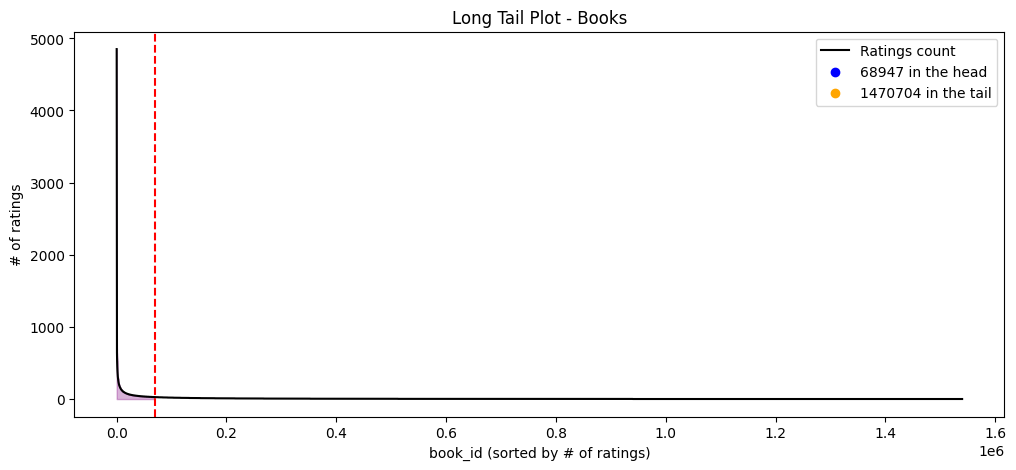

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_long_tail(df, group_col, title, fraction=0.1):
    """
    Plots a long-tail distribution for the given group_col in df,
    shading the 'head' portion that accounts for 'fraction' of total ratings.
    """
    # 1. Count how many ratings each group_col has, then sort in descending order.
    counts = df.groupby(group_col)['rating'].count().sort_values(ascending=False)
    
    # 2. Calculate the total number of ratings and the cumulative sum of ratings across items/users.
    total_ratings = counts.sum()
    cumsum = counts.cumsum()
    
    # 3. Find the threshold at which 'fraction' of total ratings is reached.
    threshold = fraction * total_ratings
    
    # 4. The head size is how many items/users are needed to reach that threshold.
    head_size = (cumsum <= threshold).sum()
    
    # 5. The tail size is the remainder of items/users after the head.
    tail_size = len(counts) - head_size
    
    # 6. Plot the distribution
    plt.figure(figsize=(12, 5))
    
    # 6a. Plot the counts (number of ratings) in descending order
    plt.plot(range(len(counts)), counts, color='black', label='Ratings count')
    
    # 6b. Shade the 'head' portion
    plt.fill_between(range(head_size), counts.iloc[:head_size], color='purple', alpha=0.3)
    
    # 6c. Draw a vertical line to separate the head and tail
    plt.axvline(x=head_size, color='red', linestyle='--')
    
    # 7. Add dummy points for legend labels (head vs. tail counts)
    plt.scatter([], [], color='blue', label=f'{head_size} in the head')
    plt.scatter([], [], color='orange', label=f'{tail_size} in the tail')
    
    # 8. Label and title
    plt.title(title)
    plt.xlabel(f'{group_col} (sorted by # of ratings)')
    plt.ylabel('# of ratings')
    # 9. Show legend
    plt.legend()
    
    # 10. Display the plot
    plt.show()

# -- Long Tail Plot for Books (ratings received) --
plot_long_tail(
    df=explicit_feedback_df,      # DataFrame with valid ratings
    group_col='book_id',          # Group by book to see ratings each book received
    title='Long Tail Plot - Books', 
    fraction=0.5                 # Top % threshold
)


This is a clear demonstration of the **long tail phenomenon**, where a small number of popular books items are completely dominating user interaction, while the majority of content is rarely rated. Even after our careful resampling for the top 5 percent most active users, the long tail effect persists. This plot shows the top % of books on Goodreads ranked by the number of ratings received. Unsurprisingly, a small group of books garners the majority of attention, most likely bestsellers, classics, or books with high media exposure. The remaining books fall into the long tail, many with minimal visibility. This highlights the importance of recommendation strategies that not only reinforce popular titles but also surface niche or under-discovered books to users and we will make sure to take this into account in our implementation.

In [22]:
# Calculate total ratings in the dataset
total_ratings = explicit_feedback_df['rating'].count()
# Determine the number of unique books and calculate the top 5% count
n_top_books = int(0.05 * explicit_feedback_df['book_id'].nunique())
# Sum ratings for the top 5% books (sorted by rating count in descending order)
top_5pct_books_ratings = (explicit_feedback_df
    .groupby('book_id')['rating']
    .count()
    .sort_values(ascending=False)
    .iloc[:n_top_books]
    .sum()
)
# Calculate the percentage of total ratings that these top 5% books account for
pct_top_books = (top_5pct_books_ratings / total_ratings) * 100
print(f"Top 5% of books account for {top_5pct_books_ratings} ratings, which is {pct_top_books:.2f}% of total ratings.")

Top 5% of books account for 5808308 ratings, which is 51.89% of total ratings.


We can see that there is a clear popularity here, only 5 percent of books accounting for more than majority of all recommendations. This is means we are going to have to be very careful in terms of exploitation and exploration trade offs in our recommenders, we want to ensure that the more niche books are given a chance for users with more niche tastes.

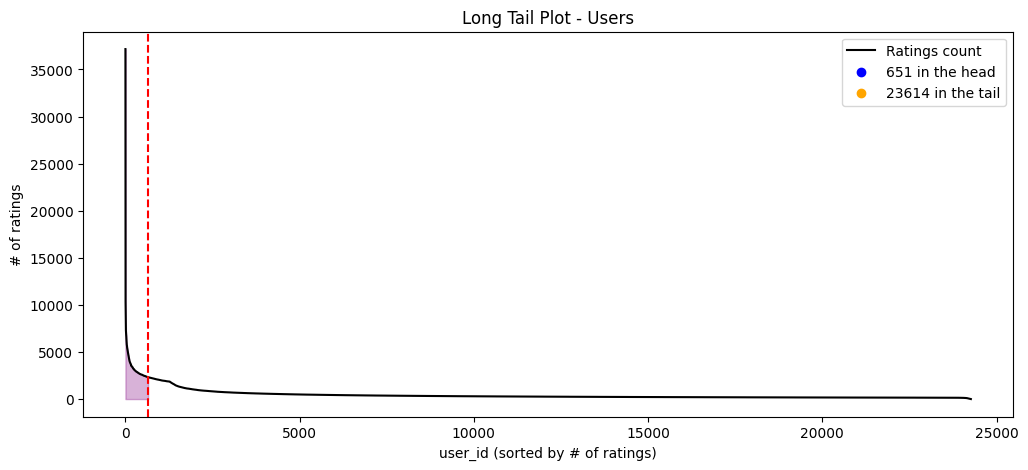

In [23]:
# -- Long Tail Plot for Users (ratings given) --
plot_long_tail(
    df=explicit_feedback_df,      # Same DataFrame
    group_col='user_id',          # Group by user to see how many ratings each user gave
    title='Long Tail Plot - Users', 
    fraction=0.2                  # Top 10% threshold
)

Here we see another very clear long tail phenomenon where the head is making up for a disproportianate amount of ratings given. This plot shows the top 10% of Goodreads users based on how many ratings they've given. Even within this already active group, we observe a fair drop-off, meaning a small number of users are highly prolific reviewers, while most contribute far fewer ratings. This behavior is typical of social reading platforms like Goodreads, where a passionate core of users drives much of the activity. Understanding this skew helps us tailor our recommenders toward both super-users and more casual readers.

In [24]:
# Determine the number of unique users and calculate the top 5% count
n_top_users = int(0.05 * explicit_feedback_df['user_id'].nunique())
# Sum ratings for the top 5% users (sorted by rating count in descending order)
top_5pct_users_ratings = (explicit_feedback_df
    .groupby('user_id')['rating']
    .count()
    .sort_values(ascending=False)
    .iloc[:n_top_users]
    .sum()
)
# Calculate the percentage of total ratings that these top 5% users account for
pct_top_users = (top_5pct_users_ratings / total_ratings) * 100
print(f"Top 5% of users account for {top_5pct_users_ratings} ratings, which is {pct_top_users:.2f}% of total ratings.")


Top 5% of users account for 3405745 ratings, which is 30.43% of total ratings.


Only the 5 percent of the users here account for a large number of ratings, meaning there are many goodreads mega book enthusiasts who have left a substantial amount of reviews more than most users. Again, we want to reiterate that we will be taking this largely into account when creating our recommender to ensure the most personalized experience all users.

#### Ratings Barplots and histograms

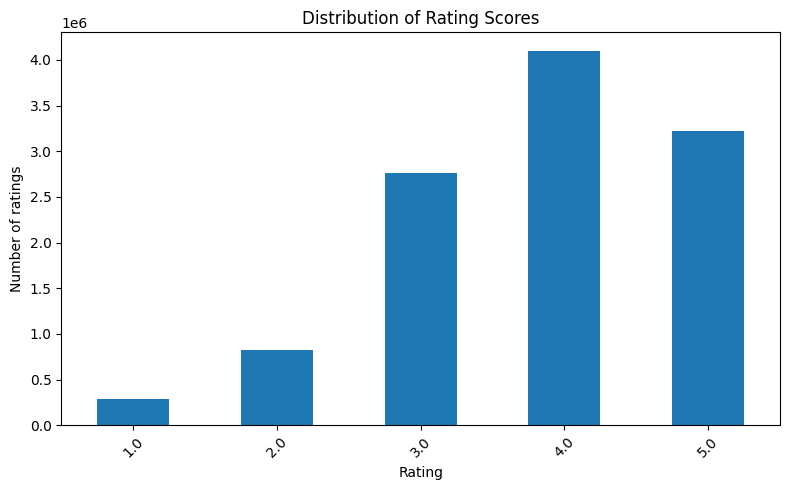

In [25]:
# Plot distribution of rating values across all books
plt.figure(figsize=(8, 5))
explicit_feedback_df['rating'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Rating')
plt.ylabel('Number of ratings')
plt.title('Distribution of Rating Scores')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This bar chart shows how users rate books on Goodreads. As expected, there's a strong **positive bias** in the ratings: most users give ratings of **4 or 5 stars**, while lower ratings (1–2) are relatively rare. This skew is very common in real-world explicit feedback data, where users are more motivated to rate books they liked rather than disliked. This told us that:
- Models should account for this imbalance (e.g., avoid over-recommending 5-star books just because they dominate).
- We may want to **normalize ratings** per user or book to reduce bias.
- Evaluation metrics that consider ranking (like NDCG or MAP) might be more useful than RMSE alone in this context.

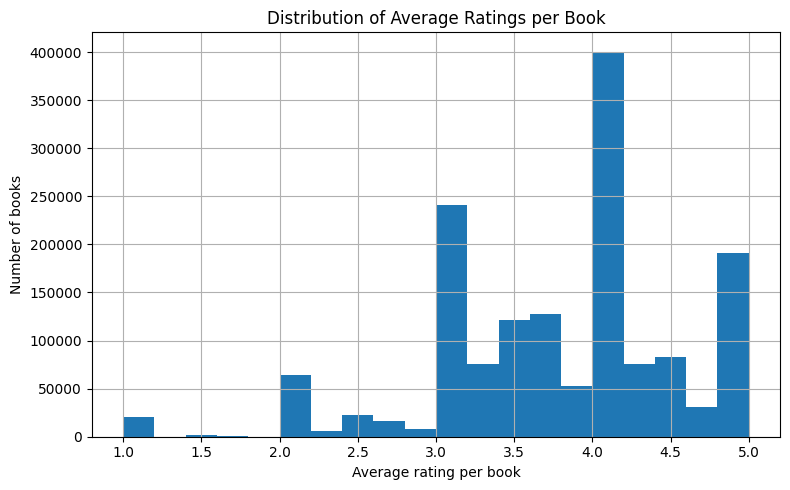

In [26]:
# Compute the average rating per book
avg_rating_per_book = explicit_feedback_df.groupby('book_id')['rating'].mean()

# Plot histogram of average ratings per book
plt.figure(figsize=(8, 5))
plt.hist(avg_rating_per_book, bins=20)
plt.xlabel('Average rating per book')
plt.ylabel('Number of books')
plt.title('Distribution of Average Ratings per Book')
plt.grid(True)
plt.tight_layout()
plt.show()


This histogram displays the distribution of average ratings **aggregated at the book level**. Most books cluster around **3.5 to 4.2**, but we also see a spike near 5.0, likely due to books with **very few but very positive ratings**.
Interestingly, the shape is less bell-curved and more spiky, indicating that some books are rated very consistently, while others might have polarized scores. This made us think about the following: 
- Books with very high or very low average ratings may suffer from **low rating count bias**.
- We should consider both `average_rating` and `ratings_count` in our books.csv file for modeling to get a fairer representation of book quality.
- Books with few ratings could be a focus for **cold-start strategies**.

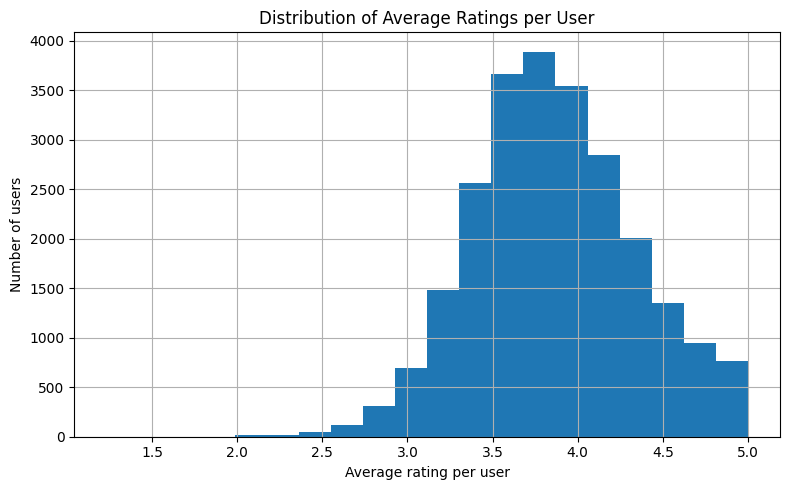

In [27]:
# Compute the average rating per user
avg_rating_per_user = explicit_feedback_df.groupby('user_id')['rating'].mean()

# Plot histogram of average ratings per user
plt.figure(figsize=(8, 5))
plt.hist(avg_rating_per_user, bins=20)
plt.xlabel('Average rating per user')
plt.ylabel('Number of users')
plt.title('Distribution of Average Ratings per User')
plt.grid(True)
plt.tight_layout()
plt.show()


This histogram shows the average rating behavior across users. The distribution is **slightly right-skewed**, meaning most users tend to give ratings between **3.5 and 4.5**. Only a small number of users consistently rate below 3.

This aligns with the earlier finding that users tend to leave positive reviews. It's also useful to see that most users aren't excessively generous (near 5) — we still have variance.

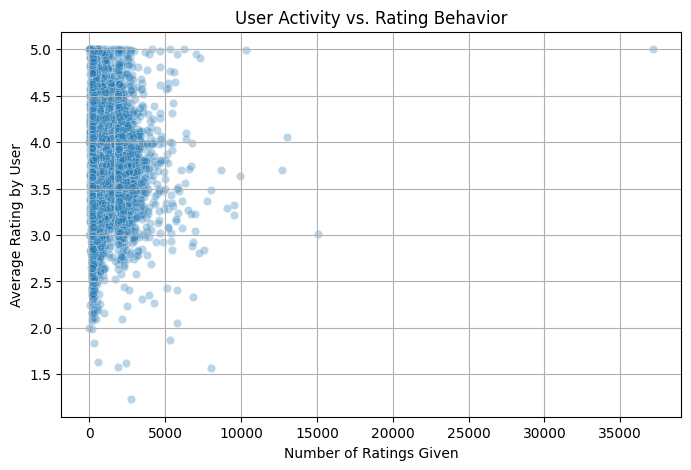

In [28]:
user_stats = explicit_feedback_df.groupby('user_id').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=user_stats, x='num_ratings', y='avg_rating', alpha=0.3)
plt.xlabel('Number of Ratings Given')
plt.ylabel('Average Rating by User')
plt.title('User Activity vs. Rating Behavior')
plt.grid(True)
plt.show()

This scatter plot explores the relationship between how many ratings a user has given and their average rating score. Most users fall in the bottom-left quadrant, suggesting that the majority have rated fewer than 500 books and tend to give high average ratings.

Interestingly, even as activity increases (some users have rated thousands of books), there isn’t a strong shift in rating behavior, telling us that highly active users still maintain a wide range of average scores.

### 3: Implicit Feedback

Implicit Feedback comes into play here in a very new and interesting way that we are exploring as an option to use as data in our recommender systems. the more obvious option would be to utilize the 0 value in a rating, signifying a click on a book but no explicit rating, which tells us a lot about a user's activity, however in the entire Goodreads dataset, this 0 "click" alue only made up an extremely small percentage of interactive data so therefore, we came up with a better idea, utilizing a new feature, is_reviewed, as a boolean variable denoting whtehr or not a user had left a review on a book once read, this interactive and implicit feedback could tell us a lot about a user, very much so enough to create a suitable recommender system, essentially though, we recognize that for some applications, such as observing cosine similarity between users in SVD(model-ased CF), a user may be dubbed similar to another user when both users give a review to a book however one is extremely uplifiting and positive while the other is a man who is absolutley horrified with what they have read, this is where the practical applications of NLP techniques come into play with us.

In [29]:
im_ratings_df = ratings_df.drop(columns=['rating'])
im_ratings_df.head()

,user_id,book_id,date_added,started_at,is_reviewed
0,1,1,Fri Aug 25 13:55:02 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,1
1,1,2,Sun Jul 30 07:44:10 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,1
2,1,3,Mon Jul 24 02:48:17 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,1
3,1,4,Mon Jul 24 02:33:09 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,1
4,1,5,Mon Jul 24 02:28:14 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,1


/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/3524285792.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_reviewed', data=im_ratings_df, palette='pastel')


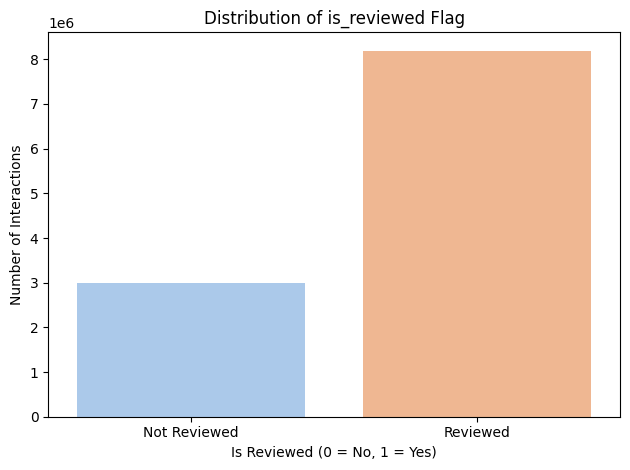

In [30]:
sns.countplot(x='is_reviewed', data=im_ratings_df, palette='pastel')
plt.title('Distribution of is_reviewed Flag')
plt.xlabel('Is Reviewed (0 = No, 1 = Yes)')
plt.ylabel('Number of Interactions')
plt.xticks([0, 1], ['Not Reviewed', 'Reviewed'])
plt.tight_layout()
plt.show()


We see here a large imbalance in our dataset which is very likely to cause bias in our models as they will learn a pattern. Since we have 8 million samples that are marked as reviewed, we can afford to undersample these interactions without losing too much valuable information or generalisability.

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/3374948139.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_reviewed', y='rating', data=ratings_df, palette='coolwarm')


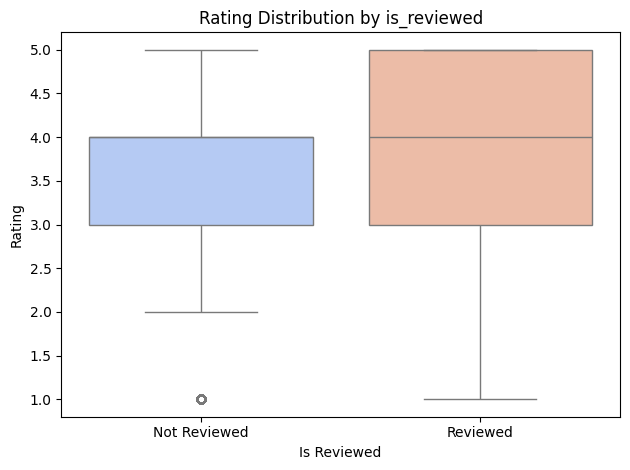

In [31]:
sns.boxplot(x='is_reviewed', y='rating', data=ratings_df, palette='coolwarm')
plt.title('Rating Distribution by is_reviewed')
plt.xlabel('Is Reviewed')
plt.ylabel('Rating')
plt.xticks([0, 1], ['Not Reviewed', 'Reviewed'])
plt.tight_layout()
plt.show()


This boxplot illustrates the distribution of rating scores for books that were reviewed (`is_reviewed = 1`) versus those that were not reviewed (`is_reviewed = 0`). 

We observe that while both distributions share a similar median rating (around 4.0), the spread and shape of the distributions reveal some interesting insights:

- **Reviewed Ratings (`is_reviewed = 1`)** tend to have a slightly wider spread and contain more extreme values on both ends (1.0 and 5.0), suggesting that users who choose to leave a review are more opinionated—either positively or negatively. This supports the idea that reviews are often motivated by strong sentiment.
  
- **Non-reviewed Ratings (`is_reviewed = 0`)** show a more condensed distribution with fewer outliers, suggesting these users may have had more neutral experiences or were less motivated to provide additional feedback.

From a recommender systems perspective, this plot validates the use of `is_reviewed` as an implicit signal for user engagement and sentiment strength. Incorporating it could help distinguish passive consumption from engaged interaction.

### 4: Contextual Data

This is where we look into the type of data which denotes outside factors when a user makes a rating or writes a review. In terms of the Goodreads dataset, this is represented as dates and times of a certain review or rating. The time at which a user makes a review can be extremely valuable for us in terms of identifying the best times at which to make a recommendation.

In [32]:
ratings_df.head()

,user_id,book_id,rating,date_added,started_at,is_reviewed
0,1,1,5.0,Fri Aug 25 13:55:02 -0700 2017,Sat Aug 26 00:00:00 -0700 2017,1
1,1,2,5.0,Sun Jul 30 07:44:10 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,1
2,1,3,3.0,Mon Jul 24 02:48:17 -0700 2017,Mon Jul 24 00:00:00 -0700 2017,1
3,1,4,4.0,Mon Jul 24 02:33:09 -0700 2017,Tue Jul 25 00:00:00 -0700 2017,1
4,1,5,4.0,Mon Jul 24 02:28:14 -0700 2017,Sun Jul 30 00:00:00 -0700 2017,1


#### Feature Extraction:

As you can see the date is not in datetime format and is actually a complex object, however we know the pattern and can thus extract all relevant dates from it to use with our context-based recommender. On top of the month, day, time etc... We engineer a new feature called time-period, which denotes whether it is morning, day, evening or night and can help us massively when creating our context-aware recommender system.

In [ ]:
# Correct datetime parsing (already done)
date_format = '%a %b %d %H:%M:%S %z %Y'
ratings_df['date_added'] = pd.to_datetime(ratings_df['date_added'], format=date_format, errors='coerce')

# Extract weekday
ratings_df['day_of_week'] = ratings_df['date_added'].dt.day_name()
ratings_df['day_of_month'] = ratings_df['date_added'].dt.month

#### Explicit Ratings Context

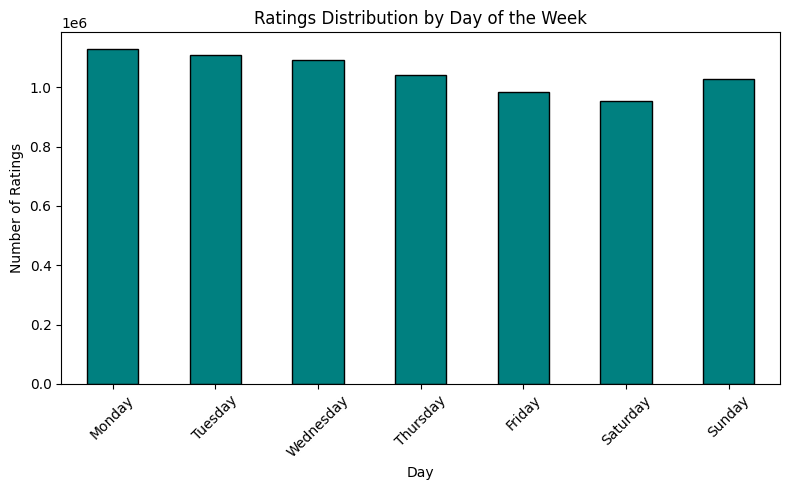

In [35]:
# Count and sort by standard week order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ratings_by_day = ratings_df['day_of_week'].value_counts().reindex(day_order)

# Plot
plt.figure(figsize=(8, 5))
ratings_by_day.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Ratings Distribution by Day of the Week')
plt.ylabel('Number of Ratings')
plt.xlabel('Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This bar chart illustrates how explicit ratings are distributed across different days of the week.

- **Weekdays dominate** in terms of user activity, with **Monday and Tuesday** showing the highest number of ratings submitted.
- As the week progresses, there is a **gradual decline** in rating volume, reaching the lowest on **Saturday**.
- Interestingly, **Sunday** sees a slight recovery in activity, which may indicate users logging books they've finished over the weekend.

Insights:
- Users appear to be **more active during the workweek**, possibly engaging with Goodreads during breaks or while working on reading goals.
- **Lower weekend activity** might suggest that users focus on reading during that time but postpone reviewing or rating until the start of the week.
- This pattern can be leveraged in **context-aware recommenders**. For example, surfacing prompts for ratings or personalized suggestions may be more effective earlier in the week.

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/2306313313.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ratings_df['month_year'] = ratings_df['date_added'].dt.to_period('M')


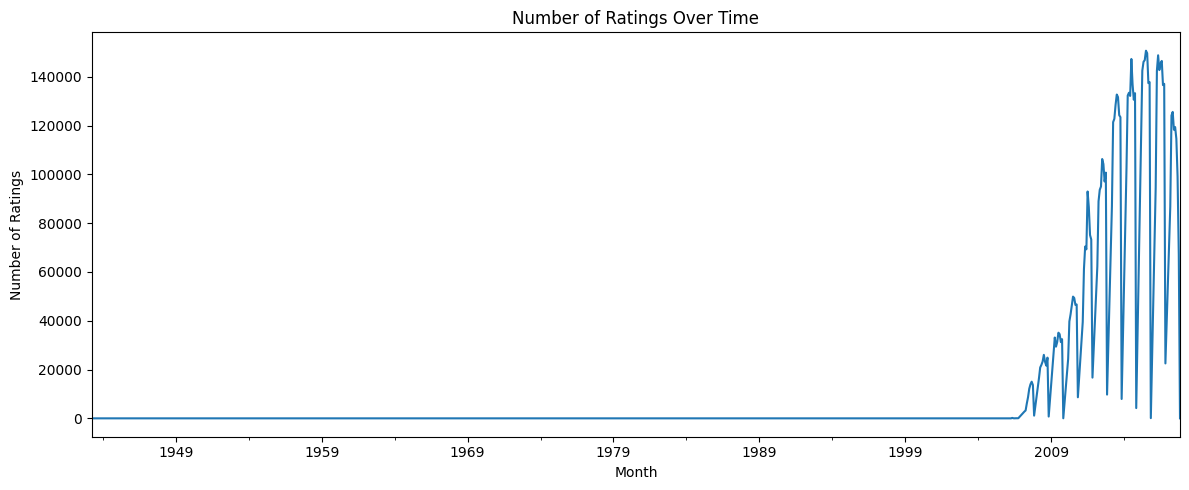

In [36]:
ratings_df['month_year'] = ratings_df['date_added'].dt.to_period('M')
monthly_counts = ratings_df.groupby('month_year').size()

monthly_counts.plot(figsize=(12, 5))
plt.title('Number of Ratings Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.tight_layout()
plt.show()

This time series plot visualizes the total number of ratings submitted per month over time.

- There is **virtually no rating activity** prior to the early 2000s, which aligns with the timeline of Goodreads’ emergence and widespread internet adoption.
- A **rapid surge in rating activity** is observed between **2007 and 2015**, reflecting Goodreads' growth in popularity.

Understanding the temporal growth in engagement helps in **time-aware recommendation modeling** and also informs us about **platform maturity** and user behavior trends over time.


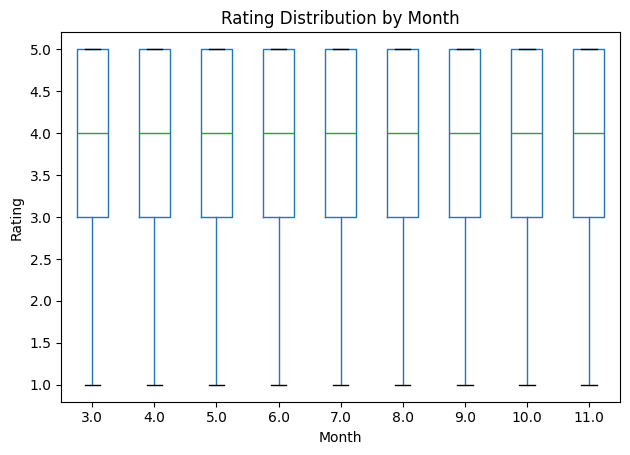

In [37]:
ratings_df['month'] = ratings_df['date_added'].dt.month
ratings_df.boxplot(column='rating', by='month', grid=False)
plt.title('Rating Distribution by Month')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()


This plot shocasing the distribution of ratings over each month shows no major change in distribution over each month, showing us that month(season) has no significant effect on the rating value so we will not be focusing on month when creating our context-aware recommender model.

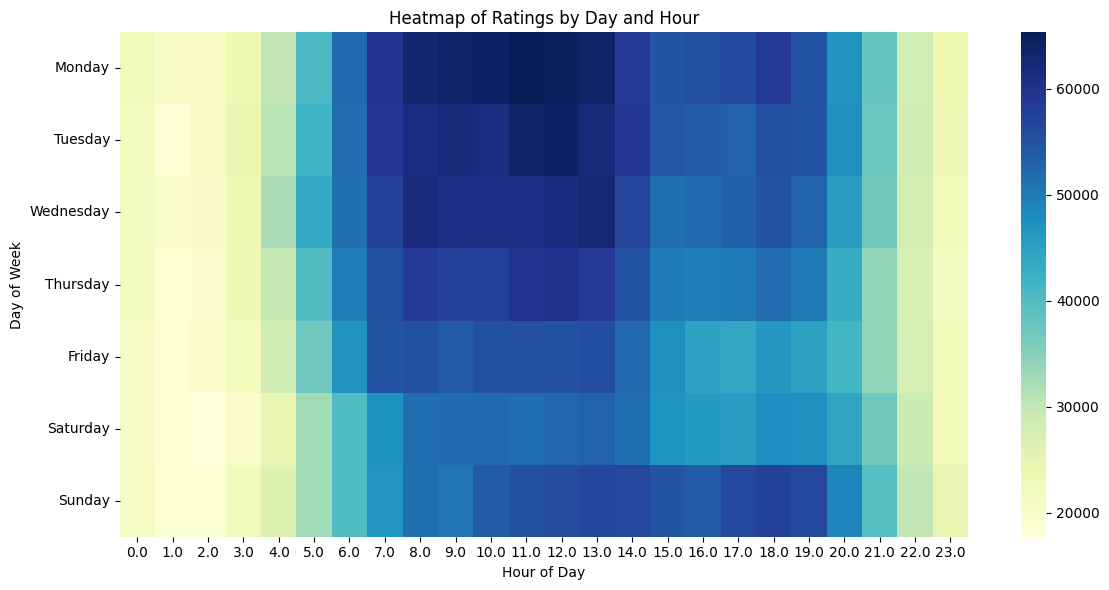

In [38]:
ratings_df['hour'] = ratings_df['date_added'].dt.hour

heatmap_data = ratings_df.groupby(['day_of_week', 'hour']).size().unstack(fill_value=0).reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu')
plt.title('Heatmap of Ratings by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

Okay here we found a more interesting spread, in this heatmap we see that during the weak, most ratings appear from aaroun 8am-2pm, with a few more later on, and Monday through Wednesday showing the highest rating intensity. Morning hours (especially around 9–11 AM) are consistently the most active across all days, suggesting users are likely rating books shortly after reading sessions or during morning routines. Evening activity is relatively lower but remains stable, indicating some engagement during downtime or just before bed.
 On saturday there are gneerally less ratings which we saw earlier in our other plot. However on sunday, most ratings occur later in the day, likely because most people sleep in or relax on sundays or possibly users catching up on weekend reads. These temporal patterns are crucial for designing our context aware recommender system.
- Recommender prompts or notifications could be timed during high-engagement hours (weekday mornings).
- Content recommendations could be adapted based on day/hour context — lighter reads on weekends, more serious or trending reads on Monday mornings.


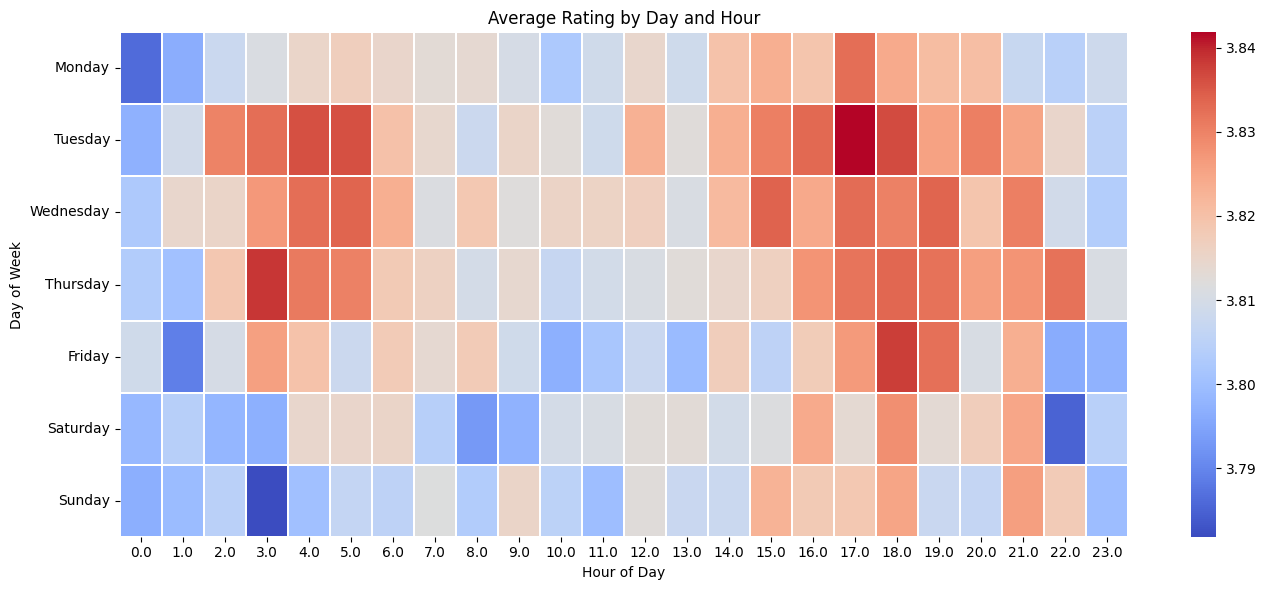

In [41]:
# Create a pivot table of average rating per hour per weekday
heatmap_data_avg = ratings_df.pivot_table(
    index='day_of_week',
    columns='hour',
    values='rating',
    aggfunc='mean'
)

# Ensure correct weekday order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data_avg = heatmap_data_avg.reindex(day_order)

# Plot the heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_avg, cmap='coolwarm', annot=False, linewidths=0.3)
plt.title('Average Rating by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

This heatmap illustrates the average rating values across each hour of the day and each day of the week. We observe a generally consistent trend in rating behavior, where average ratings hover around the 3.8–3.84 mark regardless of temporal context. Despite the small range of fluctuation, a few subtle patterns emerge: Weekday Afternoons (15:00–18:00) seem to slightly favor higher average ratings, particularly on Tuesday through Friday, possibly reflecting a calmer, more reflective time when users choose to leave reviews. Early Mornings (0:00–4:00) show slightly lower average ratings, although the difference is marginal. This could be attributed to fatigue or fewer data points during those hours. Weekends, though often associated with higher engagement, don't significantly differ in rating generosity from weekdays, suggesting a stable perception of books regardless of time. Overall, the heatmap confirms that while there may be minor temporal influences, Goodreads users tend to rate books consistently regardless of when the rating is made. This reinforces the reliability of user ratings for recommender systems, even without time-based weighting.

We should consider adding weights here to the ratings again and plotting the average weighted ratings given for each hour of a day.

In [ ]:
# Split into explicit and implicit context dataframes
excontext_df = ratings_df.drop(columns=['is_reviewed'])
imcontext_df = ratings_df.drop(columns=['rating'])

#### Implicit Feedback Context

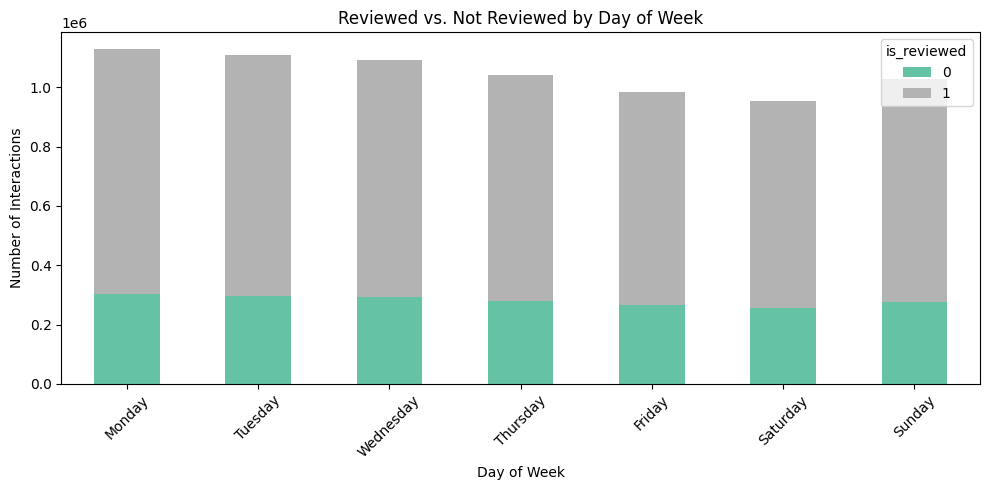

In [ ]:
ratings_df['weekday'] = ratings_df['date_added'].dt.day_name()
review_heatmap = ratings_df.groupby(['weekday', 'is_reviewed']).size().unstack(fill_value=0)
review_heatmap = review_heatmap.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

review_heatmap.plot(kind='bar', stacked=True, figsize=(10, 5), colormap='Set2')
plt.title('Reviewed vs. Not Reviewed by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This stacked bar chart shows the distribution of interactions split by review status (`is_reviewed`) across the days of the week.

Several patterns stand out:

- **Overall Consistency:** The total number of interactions is fairly consistent across the week, with only minor drops observed toward the weekend (Friday and Saturday).
- **Reviewed Interactions Dominate:** Across all days, reviewed interactions (`is_reviewed = 1`, shown in gray) vastly outnumber non-reviewed ones (`is_reviewed = 0`, shown in green). This confirms that the majority of interactions in our dataset are accompanied by textual reviews, highlighting the richness of our explicit data.
- **Slight Decrease in Reviews on Weekends:** There's a subtle shift in the ratio over the weekend—Saturday shows a slightly higher proportion of non-reviewed interactions. This may suggest more casual or passive reading behavior on weekends, as opposed to more active engagement (reviewing) during weekdays.

This breakdown reinforces the idea that user engagement (in the form of writing reviews) can vary depending on temporal context, which is useful when designing **context-aware recommenders**.

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/732219320.py:20: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/matzmuda/Desktop/Goodreads-Recommender-Solution/myev/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


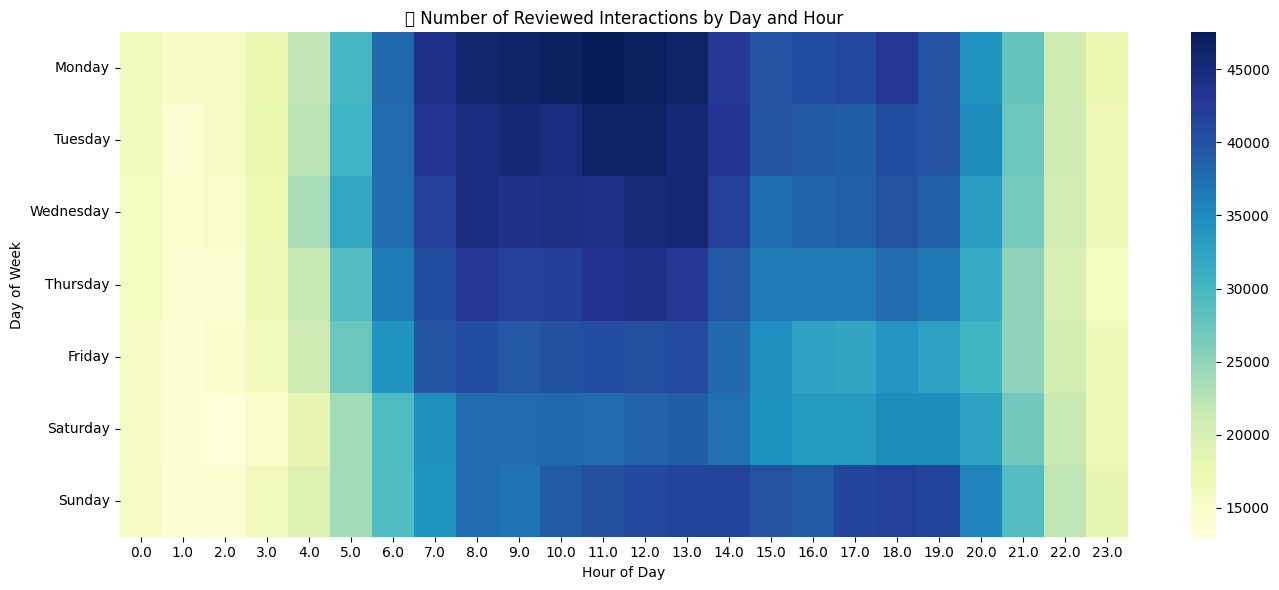

In [54]:
# Filter by review type
reviewed = ratings_df[ratings_df["is_reviewed"] == 1]
not_reviewed = ratings_df[ratings_df["is_reviewed"] == 0]

# Pivot into heatmap format
reviewed_heatmap = reviewed.pivot_table(index="day_of_week", columns="hour", values="rating", aggfunc="count")
not_reviewed_heatmap = not_reviewed.pivot_table(index="day_of_week", columns="hour", values="rating", aggfunc="count")

# Standard day order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
reviewed_heatmap = reviewed_heatmap.reindex(day_order)
not_reviewed_heatmap = not_reviewed_heatmap.reindex(day_order)

# Heatmap 1: Reviewed
plt.figure(figsize=(14, 6))
sns.heatmap(reviewed_heatmap, cmap="YlGnBu")
plt.title("📘 Number of Reviewed Interactions by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


This plot shares roughly the same pattern as the ratings field and we can draw the same conclusions.

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/795986689.py:7: UserWarning: Glyph 128213 (\N{CLOSED BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/matzmuda/Desktop/Goodreads-Recommender-Solution/myev/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128213 (\N{CLOSED BOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


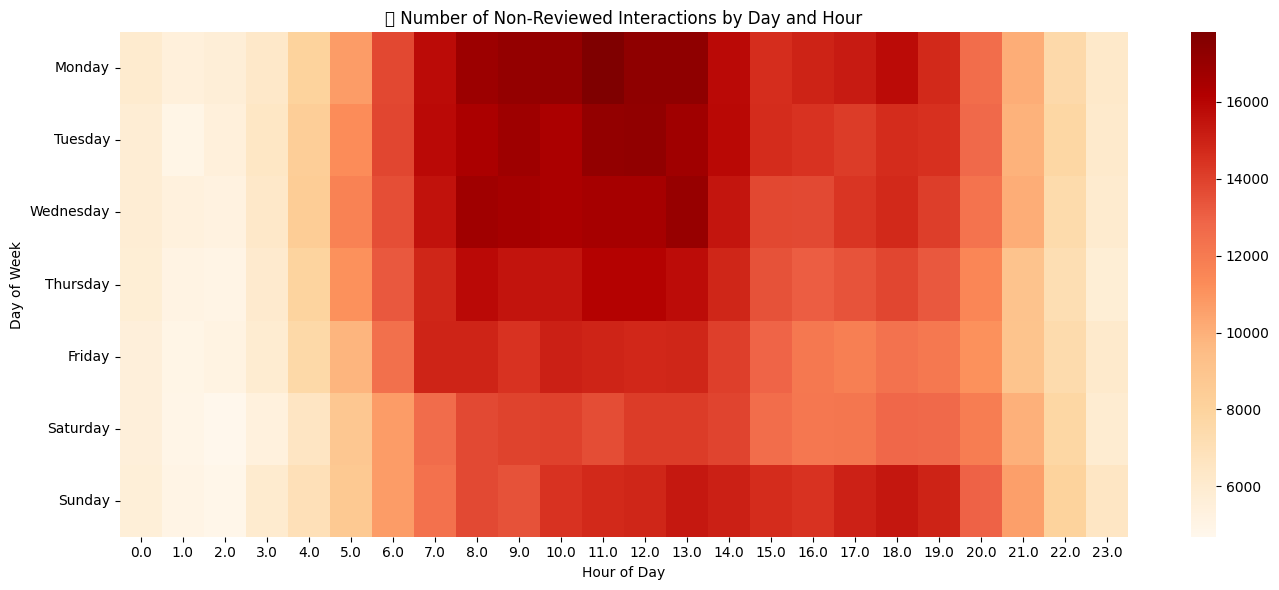

In [55]:
# Heatmap 2: Not Reviewed
plt.figure(figsize=(14, 6))
sns.heatmap(not_reviewed_heatmap, cmap="OrRd")
plt.title("📕 Number of Non-Reviewed Interactions by Day and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

The non reviewed fields also closely mirrors the dates of the previous two heatmaps, meaning we have a clear and repeatable trend here in when interactions are ocurring in the days of the week.

### 5: Metadata Part 1:

To build a meaningful and effective recommender system, it's crucial to go beyond just user interactions and dive deep into the **metadata** of the items we’re recommending 
, in this case, books. Metadata provides rich, descriptive information about each book (such as title, author, genres, language, publication year, etc.), which can be leveraged to improve both the **accuracy** and **diversity** of recommendations.
Since our mission is to help users discover books they’ll love, whether they're bestsellers or hidden gems, understanding metadata is a key part of this process. In this section, we will explore the structure and distribution of our `books_df`, identifying patterns, inconsistencies, and key features that can inform how we design our recommender strategies. By extracting insights from the content itself, we strengthen our system’s ability to serve users more thoughtfully and inclusively. First, since our genre field is a dictionary, we will format it properly so that we can perform metadata on it.

In [42]:
books_df.head()

,book_id,title,title_without_series,authors,description,publisher,publication_year,publication_month,publication_day,num_pages,...,ratings_count,country_code,popular_shelves,similar_books,format,link,url,image_url,work_id,genre
0,901426,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film,604031:,NaN,St. Martin's Press,1984.0,9.0,1.0,256.0,...,3.0,US,"count:3,name:to-read;count:1,name:p;count:1,na...",NaN,Paperback,https://www.goodreads.com/book/show/5333265-w-...,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5400751.0,"{'history, historical fiction, biography': 1}"
1,1077204,Good Harbor,Good Harbor,626222:,"Anita Diamant's international bestseller ""The ...",Simon & Schuster Audio,2001.0,10.0,1.0,NaN,...,10.0,US,"count:2634,name:to-read;count:160,name:fiction...",8709549;17074050;28937;158816;228563;11296581;...,Audio CD,https://www.goodreads.com/book/show/1333909.Go...,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1323437.0,"{'fiction': 219, 'history, historical fiction,..."
2,345682,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ...",10333:,Omnibus book club edition containing the Ladie...,"Nelson Doubleday, Inc.",1987.0,NaN,NaN,600.0,...,140.0,US,"count:58,name:to-read;count:15,name:fantasy;co...",19997;828466;1569323;425389;1176674;262740;374...,Hardcover,https://www.goodreads.com/book/show/7327624-th...,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,8948723.0,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."
3,90033,Best Friends Forever,Best Friends Forever,9212:,Addie Downs and Valerie Adler were eight when ...,Atria Books,2009.0,7.0,14.0,368.0,...,51184.0,US,"count:7615,name:to-read;count:728,name:chick-l...",6604176;6054190;2285777;82641;7569453;7010683;...,Hardcover,https://www.goodreads.com/book/show/6066819-be...,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6243154.0,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
4,1476483,The Aeneid for Boys and Girls,The Aeneid for Boys and Girls,3041852:,"Relates in vigorous prose the tale of Aeneas, ...",Yesterday's Classics,2006.0,9.0,13.0,162.0,...,46.0,US,"count:56,name:to-read;count:10,name:currently-...",NaN,Paperback,https://www.goodreads.com/book/show/287141.The...,https://www.goodreads.com/book/show/287141.The...,https://s.gr-assets.com/assets/nophoto/book/11...,278578.0,"{'history, historical fiction, biography': 9, ..."


#### Average Rating

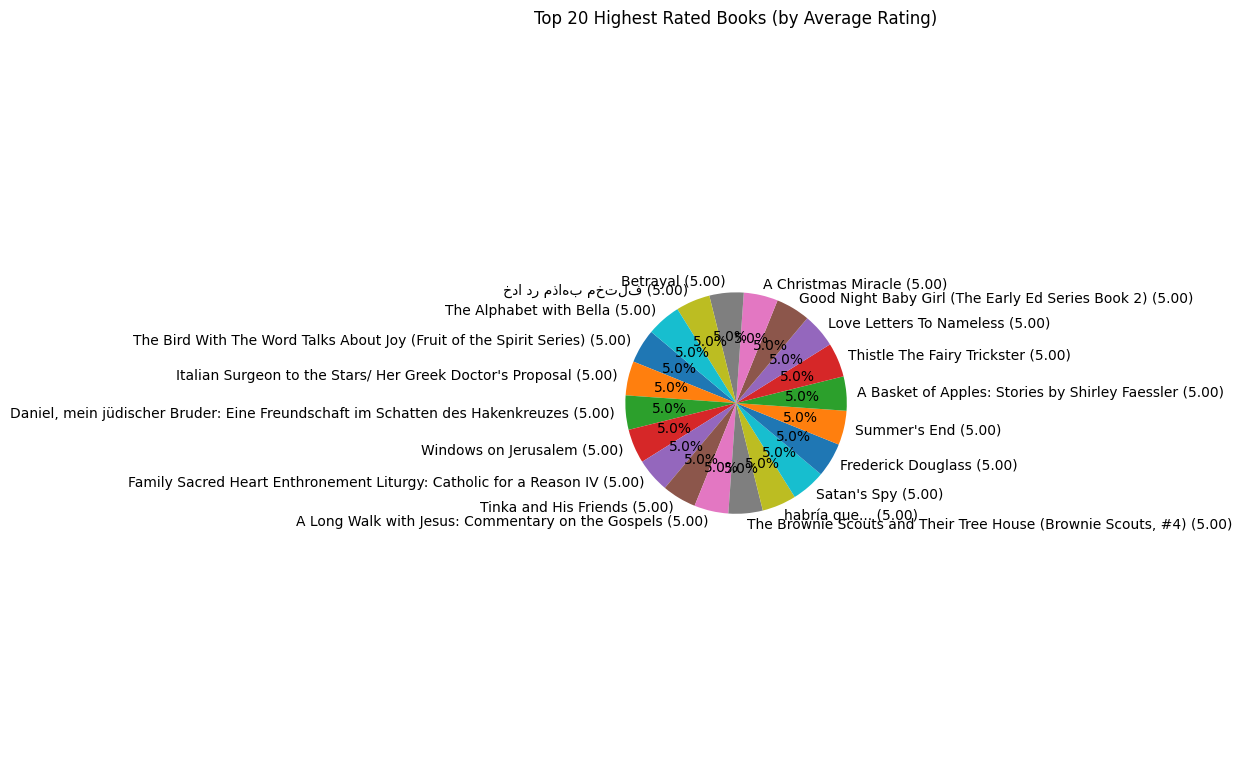

In [43]:
# Drop missing values
top_books = books_df[['title', 'average_rating']].dropna()

# Optional: Filter out books with very few ratings (e.g., less than 100) if needed
# top_books = top_books[books_df['ratings_count'] > 100]

# Get top 10 by average rating
top_books = top_books.sort_values(by='average_rating', ascending=False).head(20)

# Combine title + rating for clearer labels
labels = [f"{row['title']} ({row['average_rating']:.2f})" for _, row in top_books.iterrows()]

# Create pie chart
plt.figure(figsize=(11, 8))
plt.pie(
    top_books['average_rating'],
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Top 20 Highest Rated Books (by Average Rating)')
plt.axis('equal')  # Make it a circle
plt.tight_layout()
plt.show()


We see here the top books by highest average rated books and all of them seem quite different, we plot this to begin thinking about an implementation of a popular recommender, however, it should be noted that these averages aren't weighted based on the number of reviews and could therefore be unrepresentative of a books actual popularity, therefore we will implement both a traditional popular recommender and a bayesian average popular recommender and observe their respective affects.

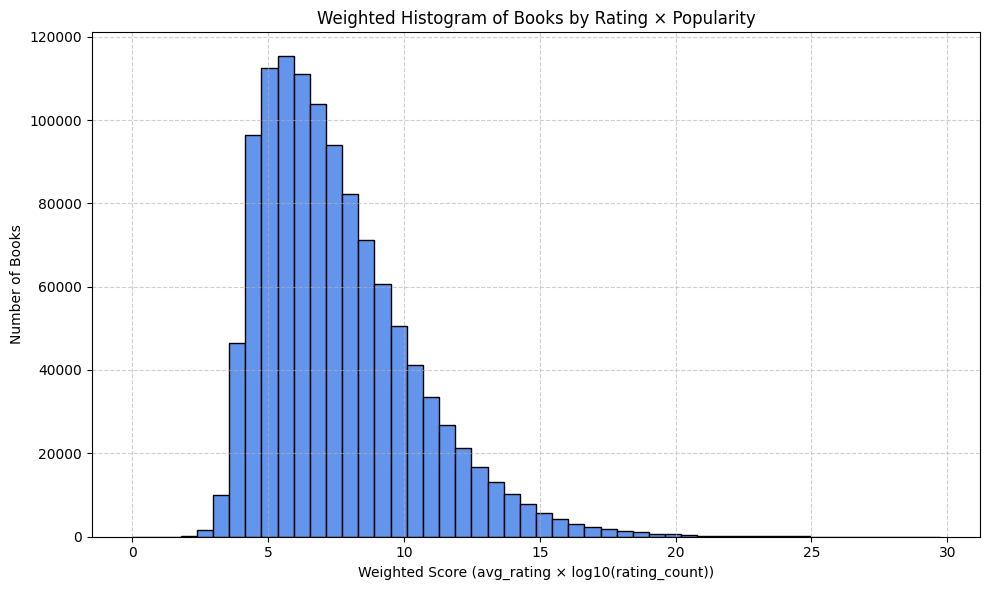

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Drop rows with missing values in required fields
books_clean = books_df.dropna(subset=['average_rating', 'ratings_count'])

# Optional: Filter out books with very few ratings
books_clean = books_clean[books_clean['ratings_count'] > 10]

# Compute weighted rating score
books_clean['weighted_score'] = books_clean['average_rating'] * np.log10(books_clean['ratings_count'])

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(books_clean['weighted_score'], bins=50, color='cornflowerblue', edgecolor='black')
plt.title('Weighted Histogram of Books by Rating × Popularity')
plt.xlabel('Weighted Score (avg_rating × log10(rating_count))')
plt.ylabel('Number of Books')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Here we computed the number of books with the highest score using a mock weighted average with the log10 of rating count, we observe that the number of books with a near "perfect rating" has dropped significantly and most books are clustered around a value of 6-8, with a steady decrease in number as the weighted score increases.

#### Average Rating and Rating Count

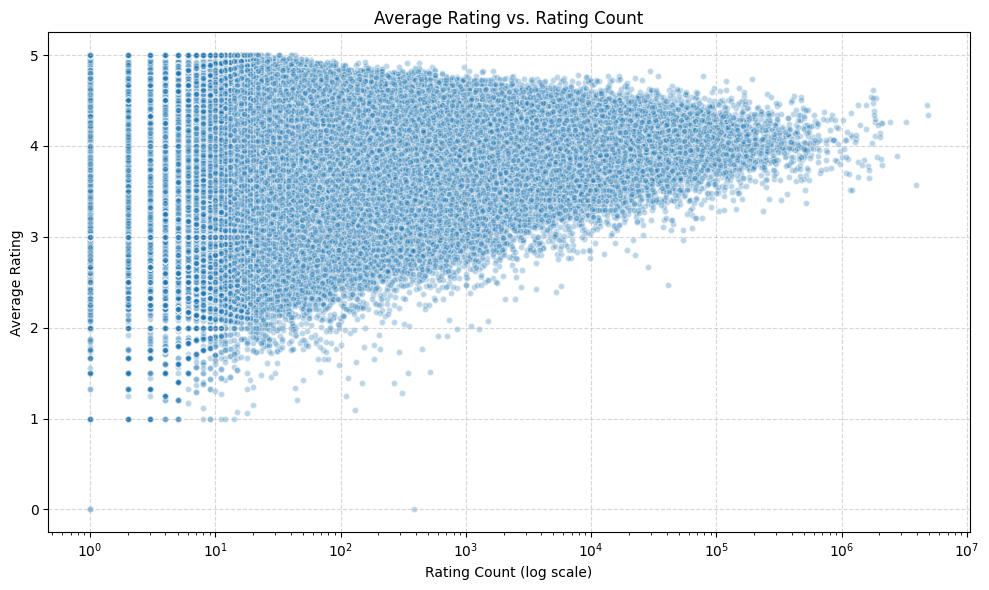

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(
    books_df['ratings_count'],
    books_df['average_rating'],
    alpha=0.3,
    edgecolors='w',
    s=20
)
plt.xscale('log')  # Because rating counts can vary drastically
plt.xlabel('Rating Count (log scale)')
plt.ylabel('Average Rating')
plt.title('Average Rating vs. Rating Count')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


This scatter plot visualizes the relationship between a book's **average rating** and its **total number of ratings**, with a logarithmic x-axis to account for the large spread in rating counts.

We can observe a few key patterns:
- Books with **very few ratings** exhibit a wide range of average scores, including extreme values (e.g., 0 or 5). This is expected due to the **instability of small sample sizes**.
- As the number of ratings increases, the average rating converges to a tighter band between **3.5 and 4.5**, reflecting more consistent reader consensus.
- A cluster of popular books (right side of the plot) maintain solid average scores but **very few highly popular books drop below 3.0**, indicating that unpopular books rarely gain traction.

We will definitely Consider applying a minimum rating count threshold (e.g., 50–100) to improve the robustness of the average rating as a feature in our recommender system.

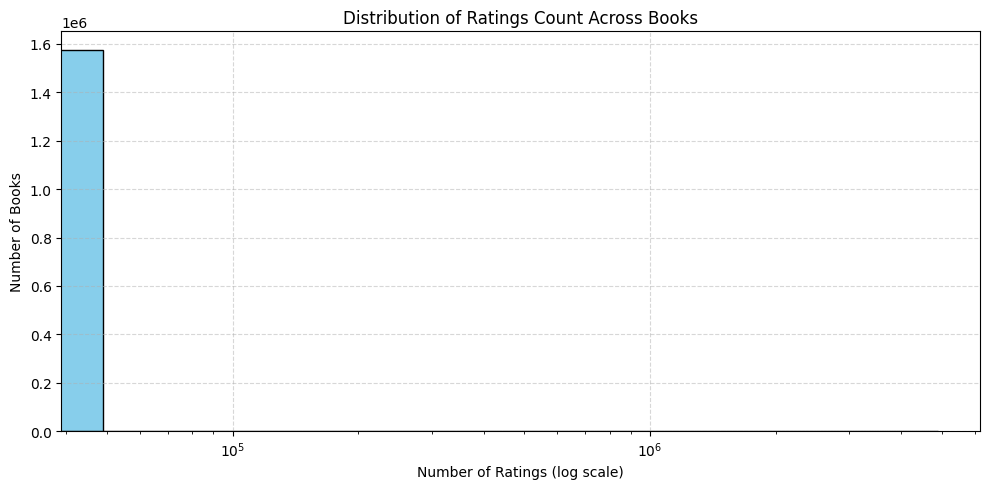

In [46]:
plt.figure(figsize=(10, 5))
plt.hist(books_df['ratings_count'], bins=100, color='skyblue', edgecolor='black')
plt.xscale('log')  # Again, rating counts have a long tail
plt.xlabel('Number of Ratings (log scale)')
plt.ylabel('Number of Books')
plt.title('Distribution of Ratings Count Across Books')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

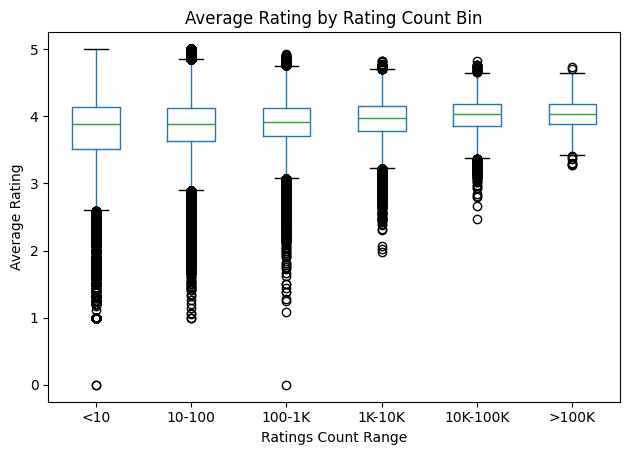

In [47]:
# Bin books into categories based on number of ratings
bins = [0, 10, 100, 1000, 10000, 100000, 1e6]
labels = ['<10', '10-100', '100-1K', '1K-10K', '10K-100K', '>100K']
books_df['ratings_bin'] = pd.cut(books_df['ratings_count'], bins=bins, labels=labels)

# Plot boxplot
plt.figure(figsize=(10, 6))
books_df.boxplot(column='average_rating', by='ratings_bin', grid=False)
plt.title('Average Rating by Rating Count Bin')
plt.suptitle('')
plt.xlabel('Ratings Count Range')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()


This box plot shows how the **average rating** varies across different **rating count ranges**, giving us a view of both the central tendency and the spread for books of varying popularity.
- Books with **fewer than 10 ratings** show a wide spread and include extreme outliers (near 0 and 5), indicating low reliability due to small sample size.
- As we move to higher rating count bins, the **interquartile range (IQR)** narrows and the distribution becomes more stable.
- The median rating remains fairly **consistent across all bins**, hovering around 4.0, but books with more ratings are **less likely to receive extreme scores**.

This plot reinforces the idea that while average rating is useful, it should be **paired with rating count** to avoid over-representing low-volume, high-rated books in recommendation outputs.

#### Genres

In [48]:
import ast
from collections import Counter

# Step 1: Safely parse the genre column to Python dictionaries
def safe_parse(genre_str):
    try:
        return ast.literal_eval(genre_str) if pd.notna(genre_str) else {}
    except (ValueError, SyntaxError):
        return {}

books_df['genre_dict'] = books_df['genre'].apply(safe_parse)

# Step 2: Extract and split individual genres
def extract_genres(genre_dict):
    genres = []
    if isinstance(genre_dict, dict):
        for group in genre_dict.keys():
            if isinstance(group, str):
                split_genres = [g.strip() for g in group.split(',')]
                genres.extend(split_genres)
    return genres

books_df['genre_list'] = books_df['genre_dict'].apply(extract_genres)

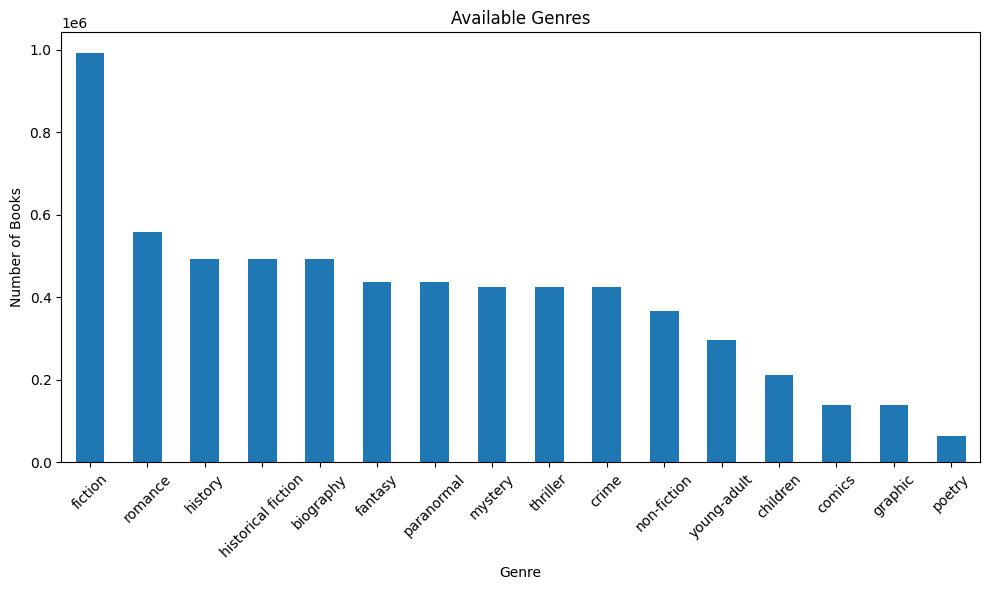

In [49]:
# Step 3: Count and plot top genres
all_genres = books_df['genre_list'].explode()
all_genres = all_genres.dropna()  # Remove actual NaN entries if any

genre_counts = Counter(all_genres)
top_genres = pd.Series(genre_counts).sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_genres.plot(kind='bar')
plt.title('Available Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

When doing this, we fount that the genres contained a very large amount of Nan values, likely as a result of incorrect parsing during APi pulling but we still have a very large representation of the following genres, we will consider down sampling both our implicit and explicit values for our content based recommender largely in order to include only ratings for books that contain valid genre types so that we can effectively make recommendations in our PoC. As for our genre spread, we observe that **Fiction** overwhelmingly dominates the genre distribution — nearly **double** the count of the next most frequent genres like **Romance**, **History**, and **Fantasy**. Other genres such as **Mystery**, **Thriller**, **Biography**, and **Paranormal** also appear prominently, suggesting that users tend to engage more with narrative-driven categories. 

**Modeling Implication**:  
To ensure the quality and relevance of recommendations, we plan to **filter both explicit and implicit ratings** to include only books with valid genre information. This step is critical for building an effective **content-based recommender** during our Proof of Concept (PoC), as the genre metadata is one of the primary pillars of similarity computation.

Additionally, we may explore **genre balancing** or **re-weighting strategies** during training to prevent the model from over-personalizing to Fiction-heavy content. Long-term, expanding the genre taxonomy and enriching it through external sources (e.g., Goodreads tags or NLP on book descriptions) may enhance genre diversity and fairness in recommendations.


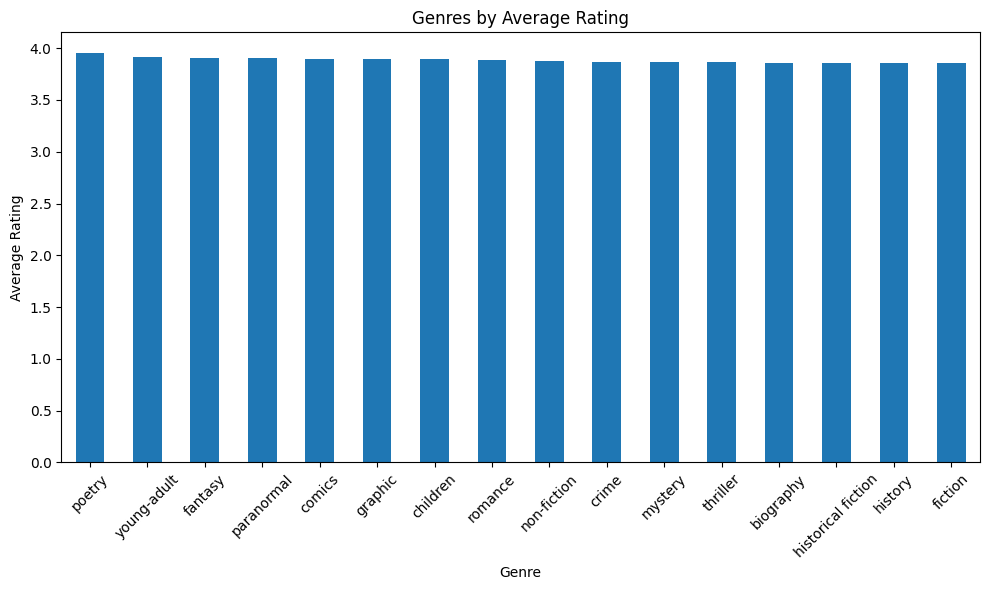

In [50]:
# Expand genres per book into rows
genre_exploded = books_df.explode('genre_list')

# Group by genre and compute average rating
genre_rating = genre_exploded.groupby('genre_list')['average_rating'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
genre_rating.plot(kind='bar')
plt.title('Genres by Average Rating')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From this plot on Average rating, we see no clear difference throughout each genre which reinforces the idea that users will normally give a positive rating when bothered to actually make a rating.

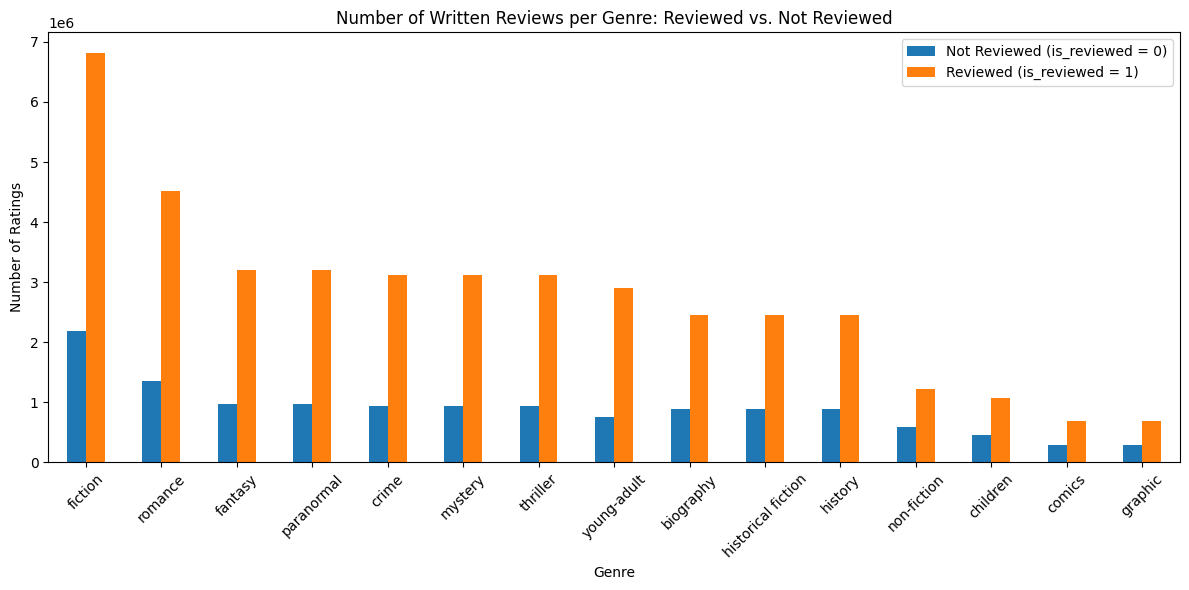

In [51]:
# Step 1: Explode genre list so each genre is in its own row
books_genres = books_df[['book_id', 'genre_list']].explode('genre_list')

# Step 2: Merge genres with ratings to attach review info
ratings_with_genre = pd.merge(
    ratings_df[['book_id', 'is_reviewed']],
    books_genres,
    on='book_id',
    how='inner'
)

# Step 3: Group by genre and review status
genre_review_counts = ratings_with_genre.groupby(['genre_list', 'is_reviewed']).size().unstack(fill_value=0)

# Step 4: Keep top 15 genres by total interactions for readability
top_genres = genre_review_counts.sum(axis=1).sort_values(ascending=False).head(15)
genre_review_counts = genre_review_counts.loc[top_genres.index]

# Step 5: Plot side-by-side bars
genre_review_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Written Reviews per Genre: Reviewed vs. Not Reviewed')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.legend(['Not Reviewed (is_reviewed = 0)', 'Reviewed (is_reviewed = 1)'])
plt.tight_layout()
plt.show()


This comparative bar chart shows the number of ratings each genre receives, separated by whether the rating includes a written review (`is_reviewed = 1`) or not (`is_reviewed = 0`).
- **All top genres receive significantly more reviewed ratings than unreviewed ones**, suggesting users are more likely to leave written reviews in genres they are highly engaged with.
- **Fiction dominates** overall, both in terms of reviewed and unreviewed ratings. This is consistent with its popularity across other plots, reinforcing its dominance in the Goodreads dataset.
- **Genres like Romance, Fantasy, and Young-Adult** follow fiction and show a similar pattern: reviewed ratings far outpace unreviewed ones. This may indicate that readers in these genres are **more expressive or community-driven**, sharing thoughts more frequently.
- **Genres like Non-Fiction, Comics, and Graphic** novels receive fewer reviews proportionally. These genres may have a larger silent/consumer audience or readers who don’t feel as compelled to write about them.
- The relatively **small review gap** for genres like Crime, Thriller, and Mystery may suggest that readers in these categories are more evenly split between casual consumers and reviewers.

In terms of our recommenders:
- Since genres have varying levels of review engagement, we might want to **weight genres differently** when building our content-based recommender.
- The data also supports tailoring models to **heavily reviewed genres** (like Fiction/Fantasy) where content-based filtering can be strongly reinforced with user-generated text features (e.g., sentiment from reviews or keyword extraction).
- Conversely, genres with low review counts may benefit more from **hybrid approaches** that rely on implicit behavior and collaborative filtering.

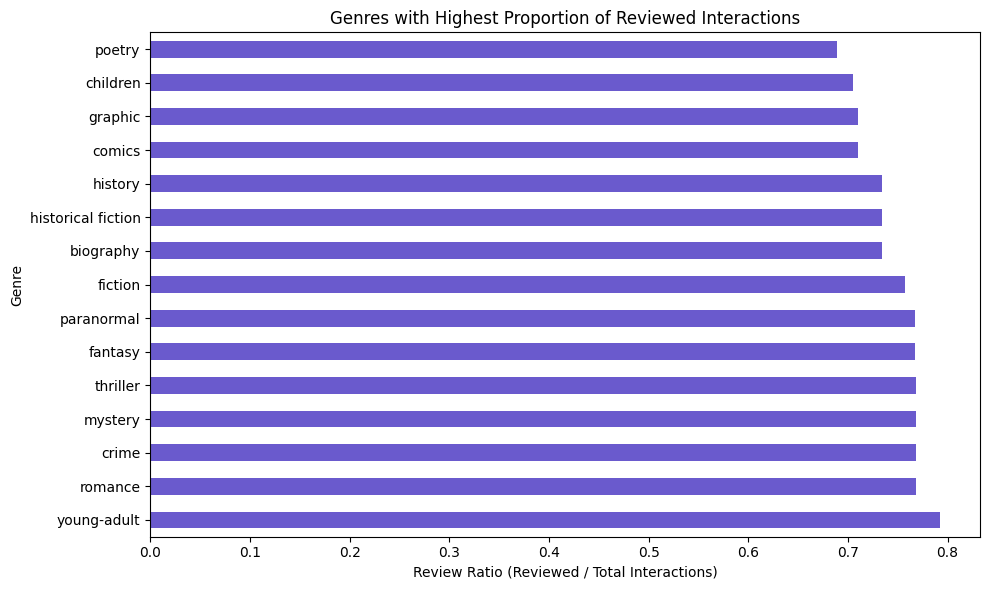

In [52]:
# Step 1: Merge genres into ratings_df
ratings_with_genres = im_ratings_df.merge(
    books_df[['book_id', 'genre_list']], on='book_id', how='left'
)

# Step 2: Explode multi-genre lists
genre_reviews = ratings_with_genres.explode('genre_list')

# Step 3: Group by genre and compute review ratio
genre_review_stats = genre_reviews.groupby('genre_list')['is_reviewed'].agg(['sum', 'count'])
genre_review_stats['review_ratio'] = genre_review_stats['sum'] / genre_review_stats['count']

# Step 4: Select and plot top genres by review ratio
top_genre_review_ratios = genre_review_stats.sort_values('review_ratio', ascending=False).head(15)

top_genre_review_ratios['review_ratio'].plot(kind='barh', figsize=(10, 6), color='slateblue')
plt.title('Genres with Highest Proportion of Reviewed Interactions')
plt.xlabel('Review Ratio (Reviewed / Total Interactions)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()


#### Popular Shelves

Now, we will look at the spread of popular shelves and analyze them all to see if we can gain important insights. In analyzing it, we see that it can reflect community-driven tagging behavior, like "to-read", "favorites", "owned", "audiobook", etc. Analyzing it can reveal how books are perceived, categorized, and engaged with beyond ratings.

In [ ]:
# Function to safely extract shelf names from the semicolon-separated format
def extract_shelves(shelf_str):
    if pd.isna(shelf_str):
        return []
    entries = shelf_str.split(';')
    return [entry.split(',')[1].split(':')[1].strip() for entry in entries if 'name:' in entry]

books_df['shelf_list'] = books_df['popular_shelves'].apply(extract_shelves)


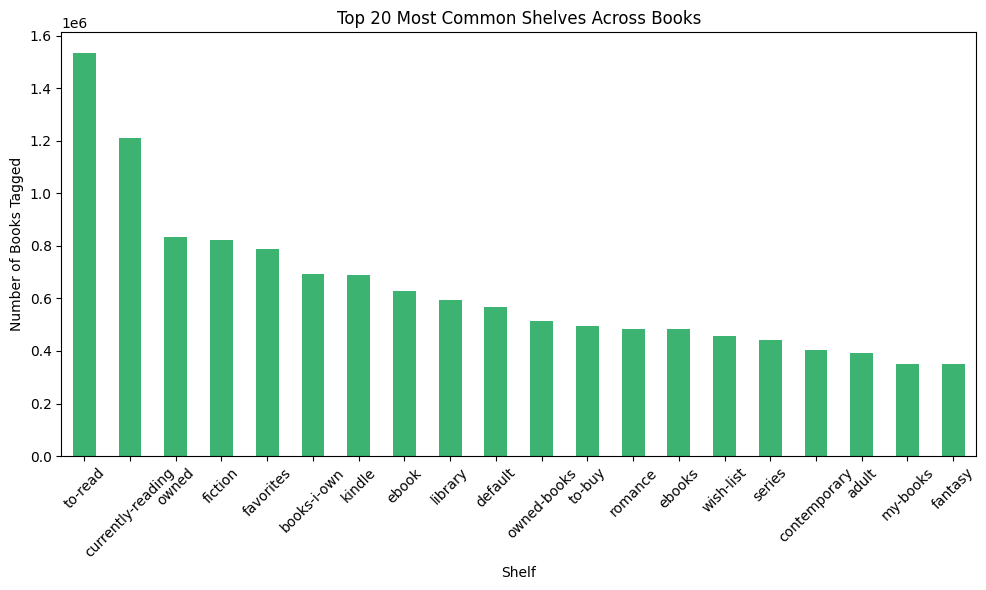

In [ ]:
# Flatten all shelves into one list
all_shelves = books_df['shelf_list'].explode().dropna()
shelf_counts = Counter(all_shelves)

# Take the top 20
top_shelves = pd.Series(shelf_counts).sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
top_shelves.plot(kind='bar', color='mediumseagreen')
plt.title('Top 20 Most Common Shelves Across Books')
plt.ylabel('Number of Books Tagged')
plt.xlabel('Shelf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart illustrates the top 20 most commonly used **popular shelves** across all books in our dataset. The shelf metadata, drawn from Goodreads community activity, gives us a window into how users **organize, track, and emotionally classify books** beyond just rating them.

Unsurprisingly, the **"to-read"** shelf dominates, appearing in over 1.5 million books. This reinforces the idea that Goodreads is often used as a **personal reading tracker**, where users bookmark books they intend to read in the future. Following closely are **"currently-reading"** and **"owned"**, which reflect the next phases in the user-book interaction journey. Together, these shelves paint a picture of **book lifecycle engagement**, from discovery, to acquisition, to active consumption.

Shelves like **"favorites"**, **"fiction"**, **"romance"**, and **"fantasy"** highlight emotional and genre-specific tagging, which are incredibly valuable for content-based recommendation systems. Meanwhile, shelves such as **"kindle"**, **"ebook"**, **"library"**, and **"owned-books"** provide insight into **reading format and access methods**, which could be incorporated as contextual signals.

A particularly interesting opportunity lies in **leveraging user-curated public shelves** as a form of **implicit feedback**. Unlike ratings, which are explicit actions, shelf placements often reflect subconscious or **behavioral signals**:

- **Books on a user’s "to-read" list** could be interpreted as interest or intent to consume.
- **Books on "favorites" or "books-I-own"** shelves may indicate emotional attachment or past purchases.
- **Comparing overlapping shelf behavior across users** could provide collaborative filtering cues, even in the absence of ratings.

If we were to build a **personalized shelf profile** for each user — essentially a vectorized version of their shelf activity — we could curate a highly specific dataset of **user-book-shelf triples**, opening the door to **deep implicit preference modeling**.

In summary, this plot not only tells us which shelves are most active across the platform, but also validates the **potential power of shelf metadata** as a rich layer of behavioral data, capable of supporting both content- and collaborative-based recommendation strategies.

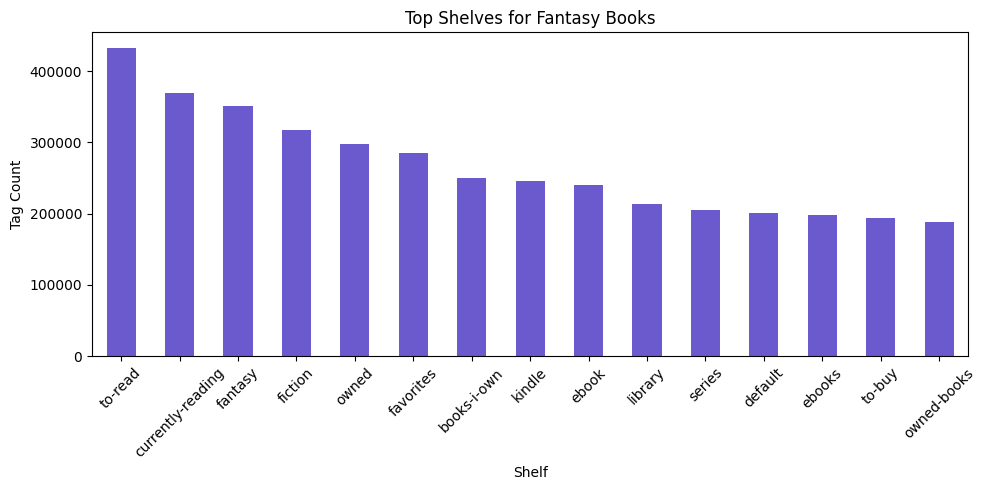

In [ ]:
# Filter to books with 'fantasy' in genre_list
fantasy_books = books_df[books_df['genre_list'].apply(lambda genres: 'fantasy' in genres if isinstance(genres, list) else False)]

# Get shelves used in those books
fantasy_shelves = fantasy_books['shelf_list'].explode().dropna()
fantasy_counts = Counter(fantasy_shelves)

# Plot top 15 shelves
pd.Series(fantasy_counts).sort_values(ascending=False).head(15).plot(
    kind='bar', figsize=(10, 5), color='slateblue'
)
plt.title('Top Shelves for Fantasy Books')
plt.ylabel('Tag Count')
plt.xlabel('Shelf')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We can see that the top shelves found for Fantasy books closely mirror the top chelves in general, again, we see that to-read is at the very top. Favorites is also up there which implies that fantasy is a favorable choice.

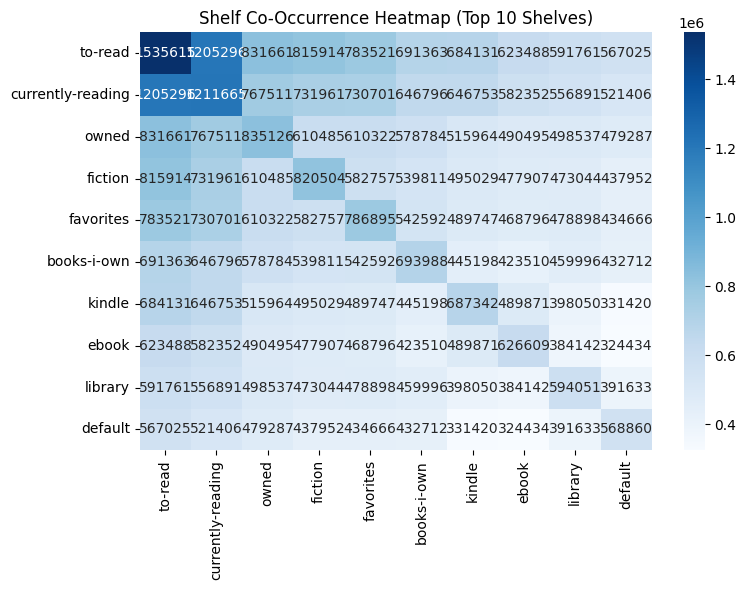

In [ ]:
# Create co-occurrence matrix for the top 10 most common shelves
top10_shelves = [s for s, _ in shelf_counts.most_common(10)]

# Create binary shelf presence matrix
def shelf_vector(shelf_list):
    return pd.Series({shelf: int(shelf in shelf_list) for shelf in top10_shelves})

shelf_matrix = books_df['shelf_list'].dropna().apply(shelf_vector)
co_matrix = shelf_matrix.T.dot(shelf_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(co_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Shelf Co-Occurrence Heatmap (Top 10 Shelves)')
plt.tight_layout()
plt.show()

Here we have a co-ocurrence heatmap of all the shelves:
- As expected, the **diagonal values are highest**, since each shelf co-occurs with itself (total usage count).
- The **strongest off-diagonal co-occurrences** include:
  - `"to-read"` with `"owned"` and `"currently-reading"` – suggesting a natural reading journey: users often shelve books they own and are reading as "to-read" beforehand.
  - `"fiction"` with `"favorites"` and `"to-read"` – reflecting high interest in narrative genres for both intention and emotional resonance.
  - `"kindle"` and `"ebooks"` – unsurprisingly, these are strongly associated due to format similarity.
  - `"books-i-own"` shares strong overlap with `"owned"`, `"library"`, and `"default"`, indicating different but semantically related ways users tag book ownership.

This got us thinking. These co-occurrence patterns can be leveraged to create **embedding representations of shelf context** — e.g., a book tagged with "favorites" and "fiction" might share behavioral traits with one tagged as "to-read" and "romance". Co-shelf patterns may also reflect **user intent or usage mode** (e.g., “currently-reading” vs. “wish list”) — helpful for recommender systems that aim to support **reading progression** or **mood-based suggestions**. These correlations provide a potential roadmap for building **shelf similarity graphs**, which could inform shelf-aware recommenders or serve as features in hybrid models.

#### Other potentially Relevant plots 

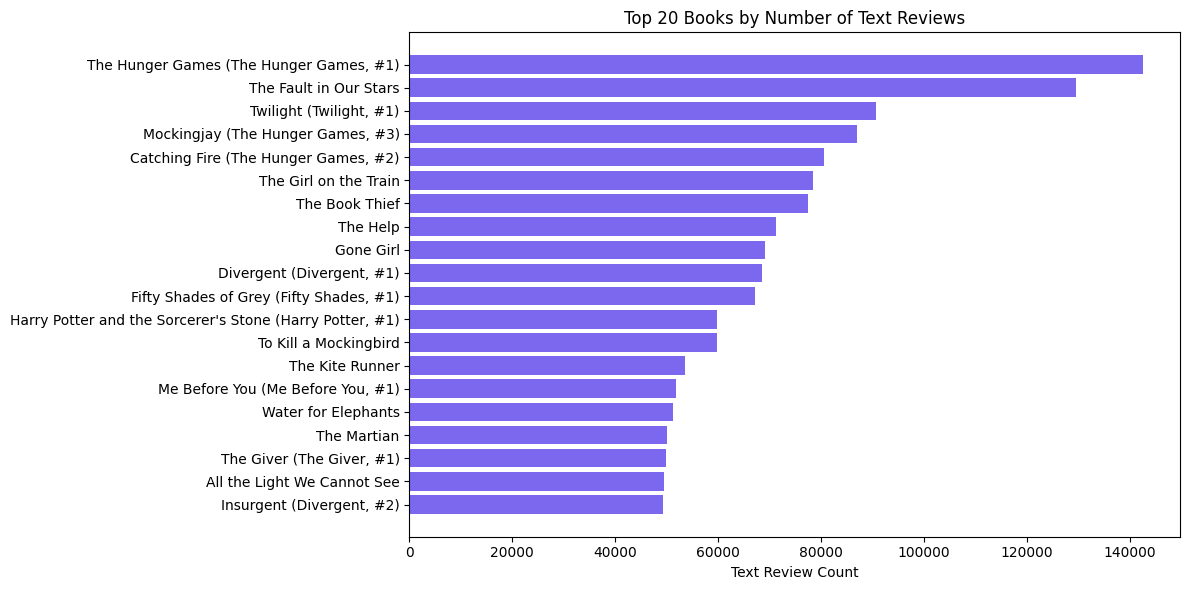

In [56]:
# Drop missing values and sort by text_reviews_count
top_reviewed_books = books_df.dropna(subset=['text_reviews_count', 'title']).sort_values(
    by='text_reviews_count', ascending=False
).head(20)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_reviewed_books['title'], top_reviewed_books['text_reviews_count'], color='mediumslateblue')
plt.xlabel('Text Review Count')
plt.title('Top 20 Books by Number of Text Reviews')
plt.gca().invert_yaxis()  # Highest bar on top
plt.tight_layout()
plt.show()

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/1923933823.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_books['pages_bin'] = pd.cut(valid_books['num_pages'], bins=bins, labels=labels)
/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/1923933823.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_per_bin = valid_books.groupby('pages_bin')['average_rating'].mean()


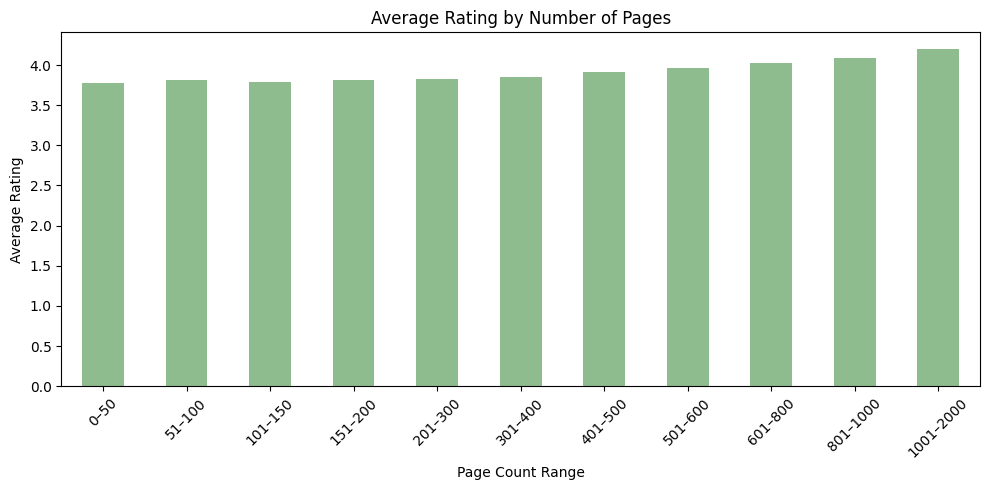

In [57]:
# Drop rows with missing num_pages or average_rating
valid_books = books_df.dropna(subset=['num_pages', 'average_rating'])

# Bin the num_pages column
bins = [0, 50, 100, 150, 200, 300, 400, 500, 600, 800, 1000, 2000]
labels = ['0–50', '51–100', '101–150', '151–200', '201–300', '301–400', '401–500', 
          '501–600', '601–800', '801–1000', '1001–2000']
valid_books['pages_bin'] = pd.cut(valid_books['num_pages'], bins=bins, labels=labels)

# Compute average rating per bin
avg_rating_per_bin = valid_books.groupby('pages_bin')['average_rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
avg_rating_per_bin.plot(kind='bar', color='darkseagreen')
plt.title('Average Rating by Number of Pages')
plt.xlabel('Page Count Range')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot shows the relationship between book length (measured by page count) and average rating. It reveals a subtle but consistent trend: books with more pages tend to receive higher average ratings. While the differences are not drastic, the ratings gradually increase as we move from shorter books (0–200 pages) toward longer ones, peaking in the 1000–2000 page range. This may suggest that readers are more invested in longer books, potentially because they offer more depth or narrative development, and are therefore rated more favorably. Alternatively, longer books might self-select for more committed readers, who are less likely to rate them poorly.

### 6: Metadata(Part 2)

Here is where we will look at the extra parts of the metadata that we have seen to be slightly less important but still potentially useful, more so than anything we aim for them to be used more as a reference to our future undertakings at this company if we were to be fully hired and integrated into the Goodreads developper community. We will explore the authors.csv file and the images and potential Computer Vision Applications we could bring to the table here.

#### Authors

In [59]:
authors_df.head()

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/4074242100.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='ratings_count', y='name', data=top_authors_by_ratings, palette='viridis')


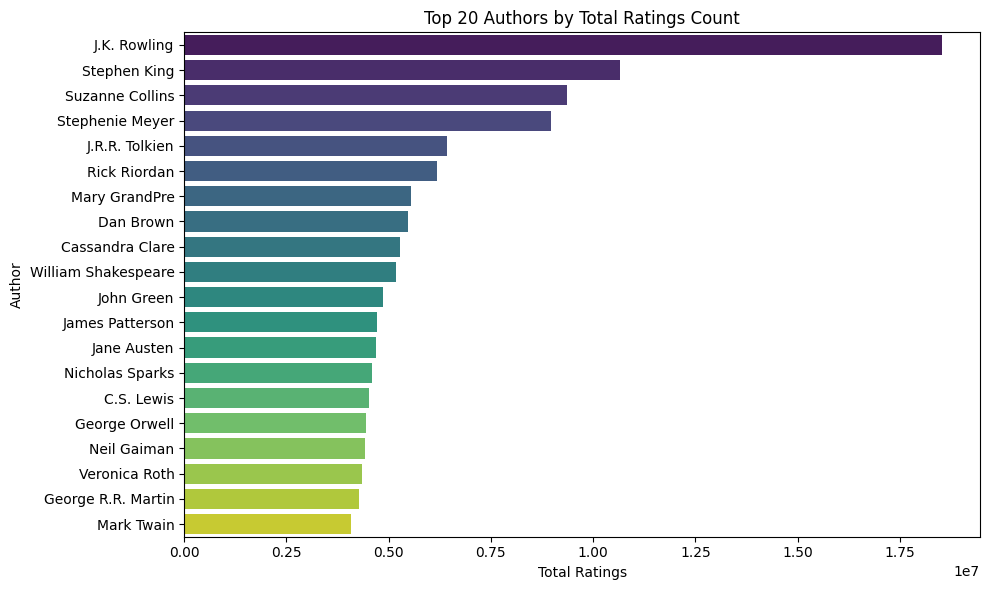

In [60]:
top_authors_by_ratings = authors_df.sort_values(by='ratings_count', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='ratings_count', y='name', data=top_authors_by_ratings, palette='viridis')
plt.title('Top 20 Authors by Total Ratings Count')
plt.xlabel('Total Ratings')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

/var/folders/kb/gytvjnzj7w32bpnby4c0ktyr0000gn/T/ipykernel_44534/1041167127.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='name', data=top_avg_rated_authors, palette='coolwarm')


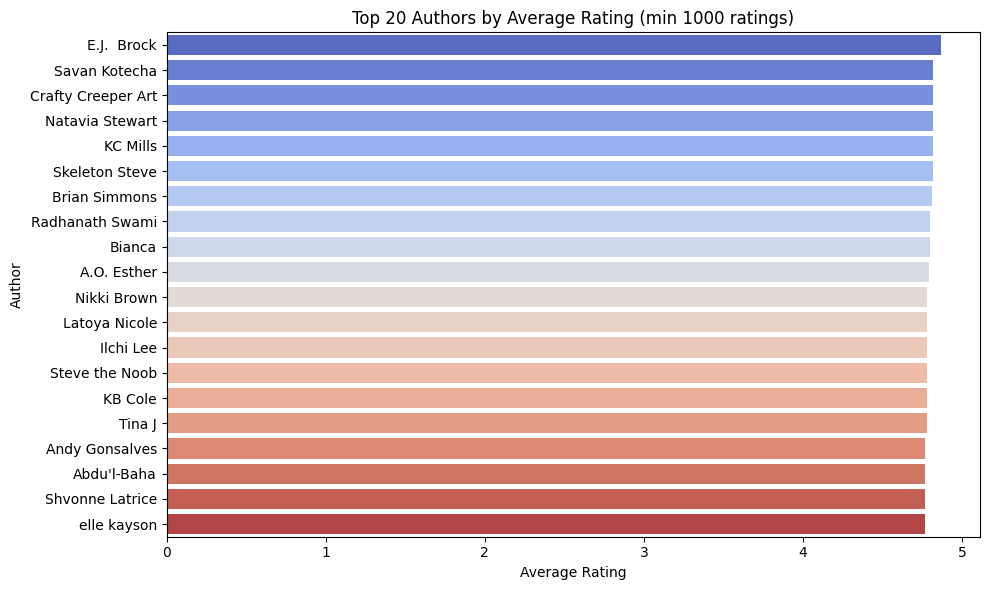

In [61]:
top_avg_rated_authors = authors_df[authors_df['ratings_count'] > 1000]  # filter for significance
top_avg_rated_authors = top_avg_rated_authors.sort_values(by='average_rating', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='average_rating', y='name', data=top_avg_rated_authors, palette='coolwarm')
plt.title('Top 20 Authors by Average Rating (min 1000 ratings)')
plt.xlabel('Average Rating')
plt.ylabel('Author')
plt.tight_layout()
plt.show()

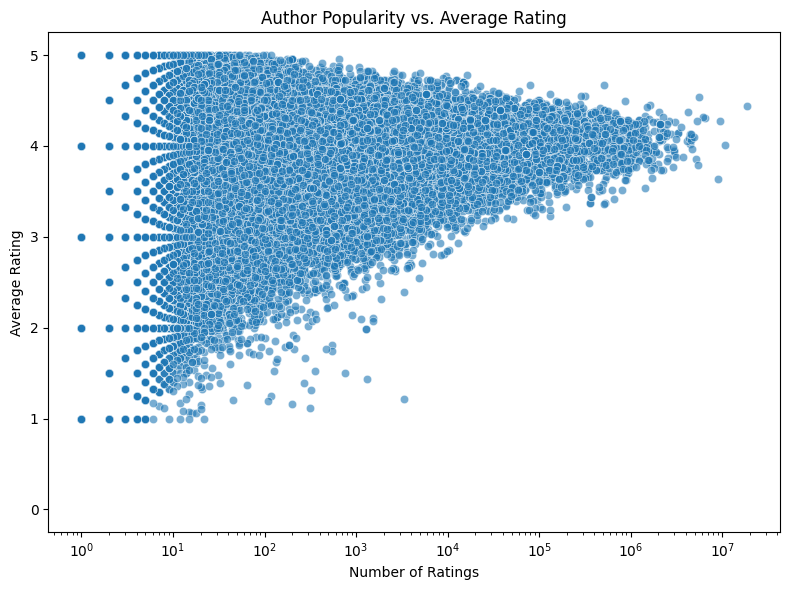

In [62]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=authors_df, x='ratings_count', y='average_rating', alpha=0.6)
plt.title('Author Popularity vs. Average Rating')
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.xscale('log')
plt.tight_layout()
plt.show()

#### Book Images

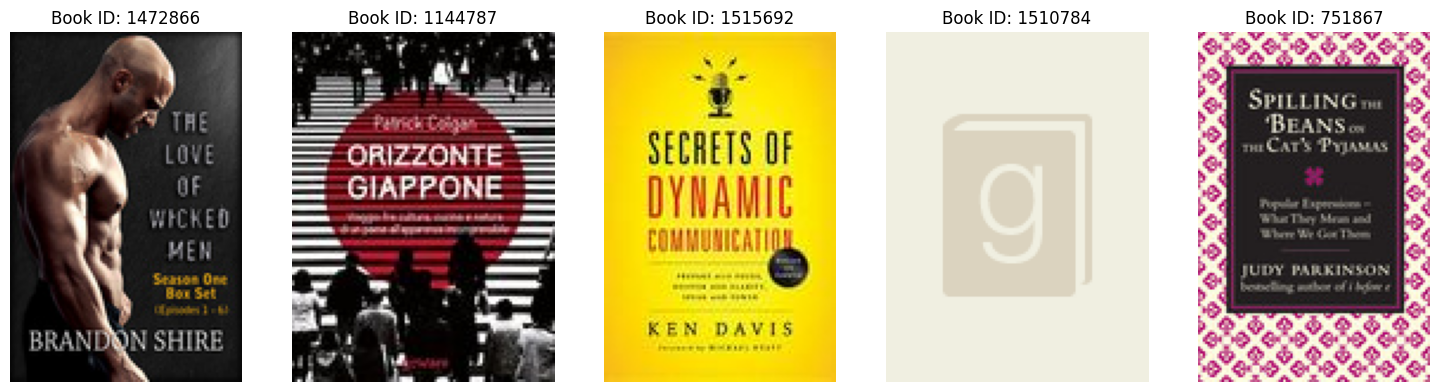

In [66]:
import requests
from PIL import Image
from io import BytesIO

# Sample 5 random books with non-null image URLs
sample_books = books_df[books_df['image_url'].notnull()].sample(5, random_state=45)

# Plotting the images
plt.figure(figsize=(15, 4))

for i, (index, row) in enumerate(sample_books.iterrows()):
    try:
        response = requests.get(row['image_url'])
        img = Image.open(BytesIO(response.content))
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Book ID: {row['book_id']}")
    except Exception as e:
        print(f"Error loading image for book_id {row['book_id']}: {e}")

plt.tight_layout()
plt.show()

The image previews above highlight the diversity of book covers in our dataset, ranging from minimalist designs to vibrant and genre-specific visuals. In the future development of our recommender system, incorporating Computer Vision (CV) techniques can significantly enhance personalization and recommendation quality.

By leveraging pretrained CNN models (e.g., ResNet or CLIP), we can extract visual embeddings from book covers and use them as additional features in both content-based and hybrid recommendation models. This would allow the system to capture aesthetic preferences (e.g., visual style, typography, color scheme) that often correlate with genre and reader interest — especially important in cold-start scenarios where limited interaction data is available.

For instance, users consistently attracted to thrillers with dark, bold imagery or romance books with softer palettes could receive suggestions aligned not just with rating history or genre, but also with visual appeal, creating a more intuitive and emotionally resonant user experience.

### 7: Contextual Metadata(Books)

In this short section we will be observing the simple timeline of book release dates.

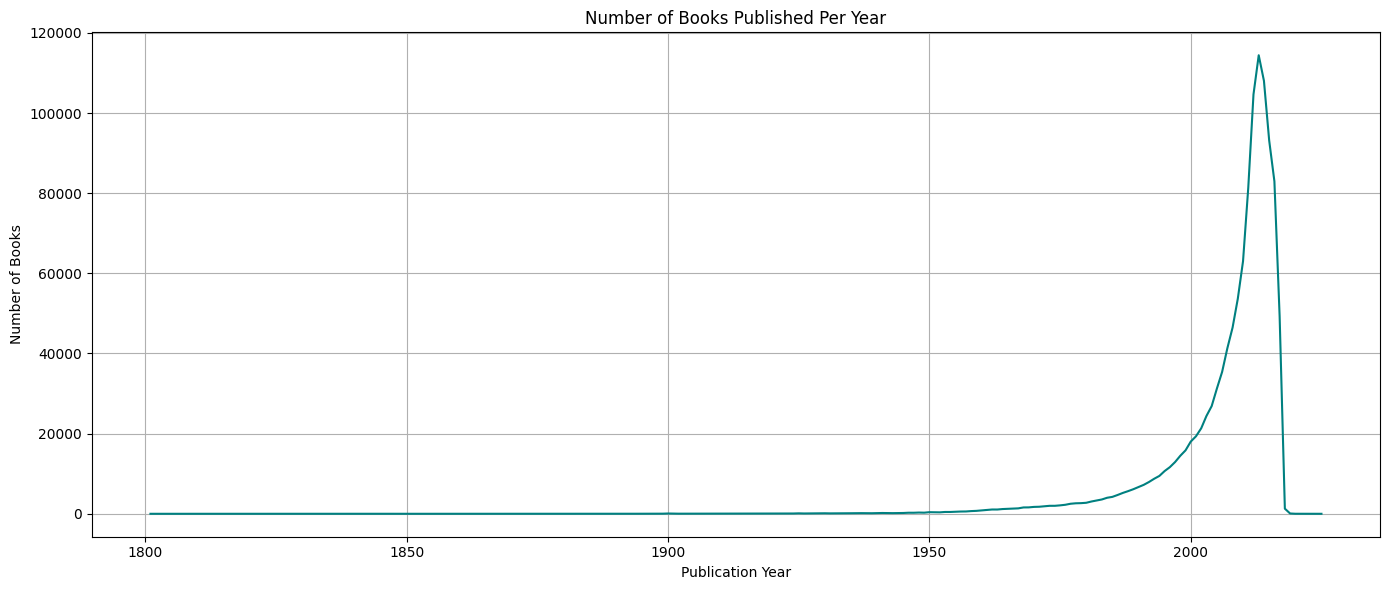

In [67]:
# Filter for valid publication years (e.g., between 1800 and 2025)
valid_years = books_df['publication_year'].dropna().astype(int)
valid_years = valid_years[(valid_years >= 1800) & (valid_years <= 2025)]

# Count books per year
pub_year_counts = valid_years.value_counts().sort_index()

# Plot the trend over time
plt.figure(figsize=(14, 6))
pub_year_counts.plot(kind='line', color='teal')
plt.title('Number of Books Published Per Year')
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.grid(True)
plt.tight_layout()
plt.show()

The plot illustrates a clear exponential growth in the number of books published from the mid-20th century onward, peaking sharply around 2013. This trend aligns with the rise of self-publishing platforms and digital printing technologies, which drastically lowered barriers to publication. The sudden drop-off post-2015 may indicate incomplete metadata in the dataset rather than an actual decline in book publishing. Understanding publication trends is valuable for temporal modeling in recommendation systems, as newer books often require strategies like cold-start mitigation while older publications may rely more on historical user interactions.

### 8: Textual Reviews

This section on our textual reviews within the reviews_df dataset is a very crucial component to our potential mission...

### 9: Feature Engineering and Extraction

NOTE THAT IN TERMS OF USERS WE DO NOT HAVE A DATASET SINCE ALL OF THIS DATA WAS SCRAPED ANONYMOUSLY FROM PUBLIC ACCESS SOURCES SO PLEASE BE CAREFUL HERE

## Evaluation Functions to use with our Recommenders

### Explicit Feedback

### Implicit Feedback

## GoodReads Current Recommender(Random)

## Popular Recommender Solution

## Collaborative Filtering RS Solution(Memory-based)

## Collaborative Filtering Solution(Model-Based)

## Content-based Recommender Solution

## Contextually-Aware Recommender Solution

## Hybrid Model Solution

## Overall Comparisons

## Conclusion to our PoC Solution